In [1]:
import sys
sys.path.append('../../')

In [2]:
preprocessed_dataset_path = 'preprocessed_dataset/'

In [3]:
from codes.docs.analysis.nimagen import stats, visualisation, graph
from codes.docs.analysis import data_preprocessing, genetic_file_preprocess

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re



Here, the volumetric dataset is preprocessed to group the same brain regions.\
Then mass univariate test is preformed, across multiple regions.

# Main analysis

In [5]:
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

In [6]:
european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

`european_volumetric_dataset_term` has 279 observations (after removal of low image quality and radiology score)

In [7]:
df = european_volumetric_dataset_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

In [8]:
df = stats.MassUnivariate.remove_outliers(
    df,
    col=['WM','GM','TBV','ICV'],
    threshold=3.5,
    remove_schemes='any')

In [9]:
df = df.drop(columns=['ASD_PRS_Pt_1e-07'])

In [11]:
# batch2_ASD_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../codes/gene_set/PRSice/output/asd/ASD_1000p.all_score',column_prefix='ASD_PRS_')

In [12]:
# df = df.drop(columns=[i for i in df.columns if 'ASD' in i])
# df = df.merge(batch2_ASD_PRS,on='ID',how='left')

In [10]:
pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
    scaling=True,
    n_components=1
)

df['PRS_pca'] = prs_pca

In [11]:
pca.explained_variance_ratio_

array([0.44137019])

After removal of ancestry outliers (using the first 3 PCs) yields 273 observations.

## Mass Univariate Tests

Performing `mass univariates` on individuals regions of both `AAL` and `DrawEM (Imperial)` atlases, we did not find any statistically significant associations using mass univariates.

NOTE: Batch 3 doesn't have AAL segmentation.

However, there is significant association between the **PRS PC1 (first principal component of the all 10 ASD PRS thresholds) and one of the PCs of the brain volumes (WM,GM, Cerebellum,Brainstem). (PRS PC1 ~ Brain-vol PC)**. More importantly, we also found that there may be some **directional pattern** in the correlation between PRS PC1 and the brain volumes.

NOTE: using Batch 2 (with AAL segmentation) we can also see association between PRS PC1 and the PCA-Brain volume.


### Using PC-Brain

In [12]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [13]:
from tqdm import tqdm

In [23]:
# groupings = ['lobe','gmwm2gether','segmented','hemisphere']
# all_groupings=powerset(groupings)
# pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
#     df,
#     dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
#     scaling=True,
#     n_components=1
# )
# df['PRS_pca'] = prs_pca
# all_combo=pd.DataFrame()
# for grouping in tqdm(all_groupings,total=16,position=0,leave=True):
#     new_df_grouping = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=grouping)
#     tissues=['WM','GM','DGM','Brainstem','Cerebellum']
#     all_tissues=powerset(tissues)
#     next(all_tissues)
#     for tissue in all_tissues:
#         new_df = data_preprocessing.Volumes.Imperial.get_segment(new_df_grouping,'column',tissue=tissue,)
#         if new_df.shape[1] == 0:
#             continue
#         pca, brain_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
#             new_df,
#             dependentVar_cols=[i for i in new_df.columns if 'Imperial' in i],
#             scaling=True, 
#             n_components=.75
#         )
        
#         _, brain_pca_mass_univariate = stats.MassUnivariate.mass_univariate(df,
#                                     cat_independentVar_cols=['sex'],
#                                     cont_independentVar_cols=['PRS_pca','GA','PMA','TBV']+ancestry,
#                                     dependentVar_cols=brain_pca)
#         temp_df = brain_pca_mass_univariate.sort_values(by=["standardize(Q('PRS_pca'))_pval"]).head(1)
#         temp_df['combo'] = str([tissue]+[grouping])
#         all_combo=pd.concat([all_combo,temp_df])
    

In [242]:
#WM,GM,DGM,Ventricle,Brainstem,Cerebellum,Background,'CSF

In [17]:
# new_df = data_preprocessing.Volumes.Imperial.get_segment(df,'column',lobe=['frontal','temporal','occipital','parietal'])

# new_df = data_preprocessing.Volumes.Imperial.get_segment(df,'column',lobe=['frontal','temporal','occipital','parietal'])
# new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(new_df,grouping=[])
# # new_df = new_df.drop(columns='Imperial 9')
# new_df = pd.concat([new_df,df[['Imperial 10','Imperial 9','Imperial 55','Imperial 56',
#                                'Imperial 15','Imperial 16',
#                                'Imperial 20','Imperial 21','Imperial 63','Imperial 64',
#                                'Imperial 24','Imperial 25','Imperial 67','Imperial 68',
#                                'Imperial 32','Imperial 33','Imperial 75','Imperial 76',
#                                'Imperial 34','Imperial 35','Imperial 77','Imperial 78',
#                                'Imperial 3','Imperial 4','Cerebellum','Brainstem']]],axis=1)

new_df = data_preprocessing.Volumes.Imperial.get_segment(df,'column',tissue=['WM','GM'])
new_df = new_df.drop(columns='Imperial 48')
new_df = pd.concat([new_df,df[['Imperial 3','Imperial 4']]],axis=1)

In [58]:
data_preprocessing.Volumes.Imperial.get_segment(df,lobe=['temporal']).columns

Index(['Imperial 11', 'Imperial 12', 'Imperial 13', 'Imperial 14',
       'Imperial 28', 'Imperial 29', 'Imperial 30', 'Imperial 31',
       'Imperial 5', 'Imperial 51', 'Imperial 52', 'Imperial 53',
       'Imperial 54', 'Imperial 57', 'Imperial 58', 'Imperial 59',
       'Imperial 6', 'Imperial 60', 'Imperial 7', 'Imperial 71', 'Imperial 72',
       'Imperial 73', 'Imperial 74', 'Imperial 8'],
      dtype='object')

In [68]:
data_preprocessing.Volumes.Imperial.get_Imperial_legends()['Imperial 11']

{'name': 'Superior temporal gyrus, middle part left GM',
 'tissue': 'GM',
 'lobe': 'temporal',
 'side': 'left',
 'segment': 'middle',
 'structure': 'Superior temporal gyrus',
 'abbr': 'STG.GM.left.middle'}

In [82]:
[(data_preprocessing.Volumes.Imperial.get_Imperial_legends()[i]['structure'],i) for i in data_preprocessing.Volumes.Imperial.get_segment(df,tissue=['DGM']).columns]

[('Hippocampus', 'Imperial 1'),
 ('Hippocampus', 'Imperial 2'),
 ('Amygdala', 'Imperial 3'),
 ('Amygdala', 'Imperial 4'),
 ('Caudate nucleus', 'Imperial 40'),
 ('Caudate nucleus', 'Imperial 41'),
 ('Thalamus', 'Imperial 42'),
 ('Thalamus', 'Imperial 43'),
 ('Subthalamic nucleus', 'Imperial 44'),
 ('Subthalamic nucleus', 'Imperial 45'),
 ('Lentiform Nucleus', 'Imperial 46'),
 ('Lentiform Nucleus', 'Imperial 47'),
 ('Intra-cranial background', 'Imperial 85'),
 ('Thalamus', 'Imperial 86'),
 ('Thalamus', 'Imperial 87')]

In [54]:
test = [#('Imperial 36','Imperial 37','Imperial 79','Imperial 80'),#frontal
        #('Imperial 38', 'Imperial 39', 'Imperial 81', 'Imperial 82'),#parietal
        #('Imperial 22','Imperial 23','Imperial 65','Imperial 66'),#occipital
        #('Imperial 15','Imperial 16','Imperial 61','Imperial 62','Imperial 26','Imperial 27','Imperial 69','Imperial 70'),
#         ('Imperial 20','Imperial 21','Imperial 63','Imperial 64'),#insula
#         ('Imperial 10','Imperial 9','Imperial 55','Imperial 56','Imperial 24','Imperial 25','Imperial 67','Imperial 68'),
        #('Imperial 11','Imperial 12','Imperial 30','Imperial 31','Imperial 57','Imperial 58','Imperial 73','Imperial 74'),
        #('Imperial 13','Imperial 14','Imperial 28','Imperial 29','Imperial 59','Imperial 60','Imperial 71','Imperial 72',),
        #('Imperial 5','Imperial 51','Imperial 52','Imperial 54','Imperial 53','Imperial 6','Imperial 7','Imperial 8'),
# ('Imperial 32','Imperial 33','Imperial 75','Imperial 76','Imperial 34','Imperial 35','Imperial 77','Imperial 78'),
('Imperial 3','Imperial 4'),#cingulate
    ('Imperial 40','Imperial 41'),('Imperial 42','Imperial 43'),('Imperial 44','Imperial 45'),('Imperial 46','Imperial 47'),('Imperial 86','Imperial 87'),
       ('Imperial 1','Imperial 2'),('Imperial 48',),
    #('Cerebellum',),
    #('Brainstem',)
]

In [55]:
all_groupings=powerset(test)
len(list(all_groupings))

256

In [56]:
all_groupings=powerset(test)
pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
    scaling=True,
    n_components=1
)
df['PRS_pca'] = prs_pca
all_combo=pd.DataFrame()
for combo in tqdm(all_groupings,total=256,position=0,leave=True):
    new_df_grouping = data_preprocessing.Volumes.Imperial.get_segment(df,'column',tissue=['WM','GM'])
    #new_df_grouping = df[[x for n in combo for x in n]]
    new_df_grouping = new_df_grouping.drop(columns=['Imperial 48'])
    new_df_grouping = pd.concat([new_df_grouping,df[[x for n in combo for x in n]]],axis=1)
    #if len([x for n in combo for x in n]) == 0:
    #    continue
    pca, brain_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
        new_df_grouping,
        dependentVar_cols=new_df_grouping.columns.tolist(),
        scaling=True, 
        n_components=.8
    )
        
    _, brain_pca_mass_univariate = stats.MassUnivariate.mass_univariate(df,
                                cat_independentVar_cols=['sex'],
                                cont_independentVar_cols=['PRS_pca','GA','PMA','TBV']+ancestry,
                                dependentVar_cols=brain_pca)
    temp_df = brain_pca_mass_univariate.sort_values(by=["standardize(Q('PRS_pca'))_pval"]).head(1)
    temp_df['combo'] = str([combo])
    all_combo=pd.concat([all_combo,temp_df])
    

100%|█████████████████████████████████████████| 256/256 [01:20<00:00,  3.20it/s]


In [240]:
test = pd.read_csv('gmwm_withdgm_pca_test.csv',index_col=0)

In [57]:
test = all_combo.sort_values(by=["standardize(Q('PRS_pca'))_pval"])
test = test[test["standardize(Q('PRS_pca'))_pval"]<0.005

In [80]:
test.combo[13]

"[(('Imperial 3', 'Imperial 4'),)]"

In [119]:
test[test["standardize(Q('PRS_pca'))_pval"]<0.05]

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,combo


In [73]:
new_df = data_preprocessing.Volumes.Imperial.get_segment(df,'column',tissue=['WM','GM'])
# new_df = new_df.drop(columns='Imperial 48')
new_df = pd.concat([new_df,df[['Imperial 3','Imperial 4']]],axis=1)

In [74]:
pca, prs_pca, prs_loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
    scaling=True,
    n_components=1
)

df['PRS_pca'] = prs_pca

pca, brain_pca, brain_loading_matrix = stats.FeatureReduction.perform_PCA(
    new_df,
    dependentVar_cols=new_df.columns.tolist(),
    scaling=True, 
    n_components=.8,
)

In [75]:
_, brain_pca_mass_univariate = stats.MassUnivariate.mass_univariate(df,
                                    cat_independentVar_cols=['sex'],
                                    cont_independentVar_cols=['PRS_pca','GA','PMA','TBV']+ancestry,
                                    dependentVar_cols=brain_pca)

In [76]:
brain_pca_mass_univariate.sort_values(by="standardize(Q('PRS_pca'))_pval")

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
Dependent_Var_7,0.125981,0.204975,-0.245663,0.094628,-0.187813,0.004802,-0.017252,0.838170,-0.167078,1.845670e-01,0.169226,1.228413e-01,-0.050152,0.454464,0.007735,0.907479,-0.026726,0.688816
Dependent_Var_2,-0.022842,0.868130,0.044542,0.826499,0.139616,0.128415,-0.120175,0.305207,-0.468953,7.522697e-03,0.220066,1.476614e-01,0.025807,0.781178,-0.041063,0.656313,-0.103179,0.265217
Dependent_Var_4,-0.094293,0.392967,0.183871,0.259658,0.073743,0.315960,-0.010638,0.909782,-0.112912,4.193265e-01,0.125422,3.029349e-01,-0.149609,0.045391,-0.051905,0.483078,-0.035403,0.633187
Dependent_Var_6,0.187117,0.065013,-0.364878,0.015091,0.058176,0.387856,0.090176,0.295063,-0.252432,4.950392e-02,0.188383,9.186889e-02,0.049313,0.470220,-0.056807,0.402327,0.023472,0.729858
Dependent_Var_1,-0.165840,0.131416,0.323388,0.046767,-0.052952,0.468822,0.027053,0.772016,-1.828482,8.607645e-31,1.219863,1.785561e-20,0.090213,0.223912,-0.002208,0.976054,0.075332,0.307560
Dependent_Var_5,-0.068141,0.521904,0.132874,0.397983,0.037147,0.600104,-0.292335,0.001383,0.347451,1.038270e-02,-0.203917,8.295275e-02,-0.086443,0.229377,-0.057429,0.421009,0.025329,0.723227
Dependent_Var_0,-0.032412,0.693523,0.063203,0.602921,0.017628,0.747590,-0.097690,0.163566,-0.278906,7.826593e-03,6.456296,1.918287e-174,0.009991,0.857221,-0.014257,0.796018,-0.026131,0.636565
Dependent_Var_3,0.043196,0.726438,-0.084232,0.644185,0.016824,0.837875,0.223198,0.034405,-0.128645,4.110035e-01,0.085416,5.304835e-01,0.013603,0.870377,0.081095,0.327734,-0.056547,0.495893
Dependent_Var_8,0.119388,0.215540,-0.232807,0.102411,0.011381,0.859105,-0.108505,0.186098,0.092987,4.459565e-01,-0.008254,9.380118e-01,-0.010493,0.871751,0.052925,0.412580,-0.003871,0.952311
Dependent_Var_9,0.149730,0.096944,-0.291974,0.028734,-0.003040,0.959546,0.195196,0.011291,-0.107888,3.442352e-01,0.079185,4.250420e-01,-0.104768,0.085495,-0.049230,0.414830,-0.110475,0.068685


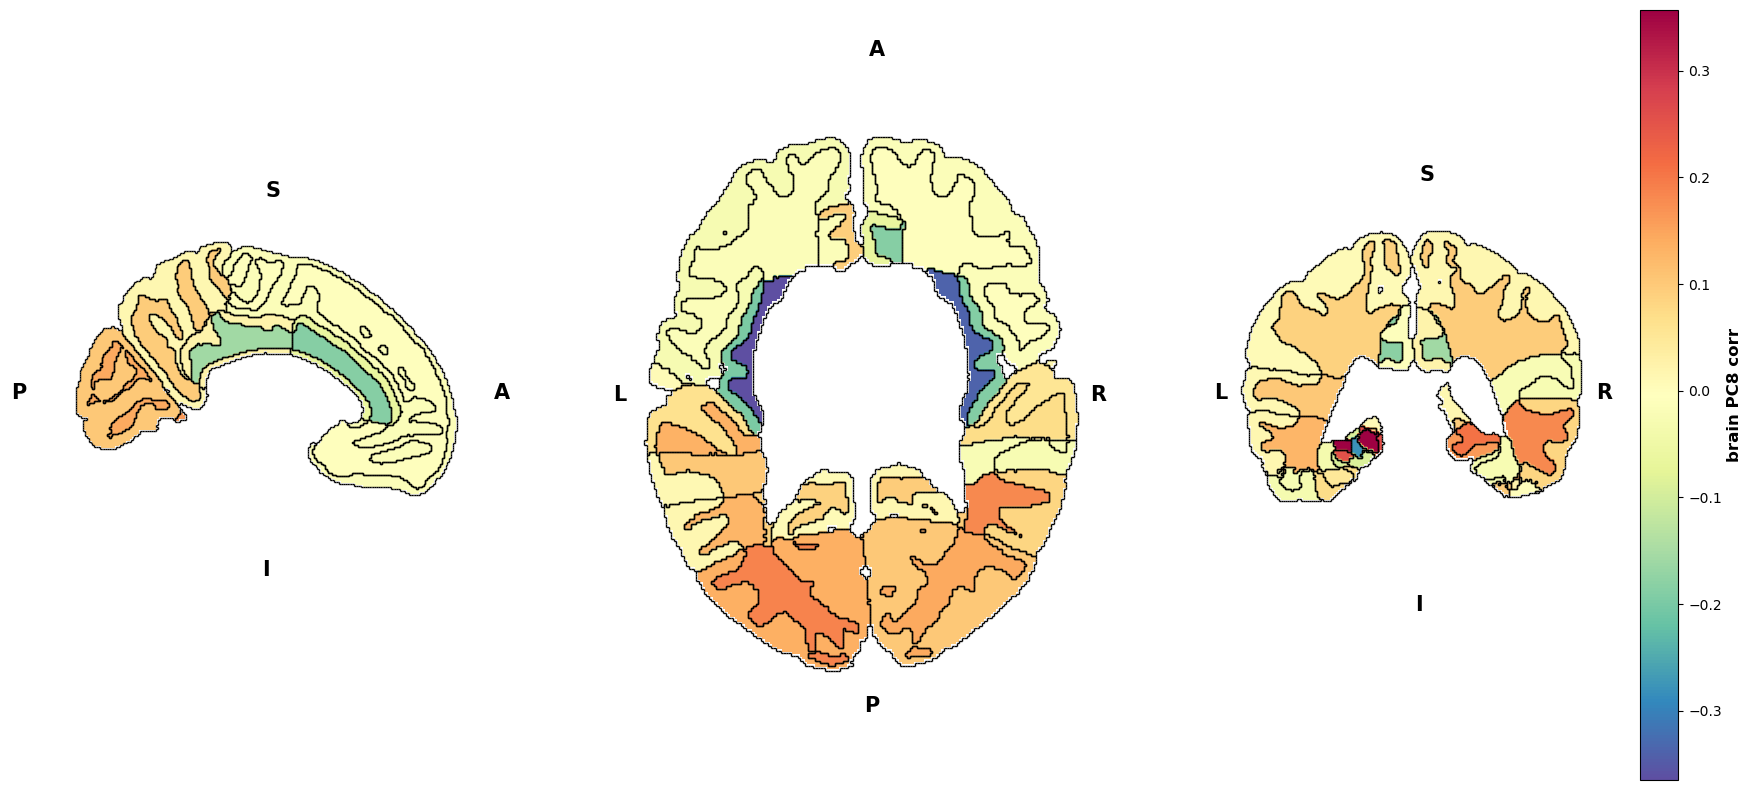

In [198]:
plot_labels = [int(i.replace('Imperial ','')) for i in brain_loading_matrix.index]
brain_plot_value_values = brain_loading_matrix[7].values
brain_plot_values = dict(zip(plot_labels,brain_plot_value_values)) 

# fig,ax = plt.subplots(3,3,figsize=(12,8))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
#     atlas_slice=120,
    plot_values=brain_plot_values,
    regions_to_hide=[i for i in range(1,88) if i not in plot_labels],
    outline_regions_to_hide = False,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
#     axes=ax[0],
#     fig=fig,
    cb_title='brain PC8 corr')

In [136]:
ROIs_coord_Imperial = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/Imperial/atlas_t40.nii.gz')
ROIs_coord_Imperial['Label'] = [f'Imperial {int(i)}' for i in ROIs_coord_Imperial['Label']]

In [174]:
new_ROIs_coord_Imperial = ROIs_coord_Imperial.set_index('Label').T.copy()
new_ROIs_coord_Imperial = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(new_ROIs_coord_Imperial,grouping=['gmwm2gether'],operation='mean',drop_duplicates=False).T
new_ROIs_coord_Imperial = new_ROIs_coord_Imperial.drop([i for i in new_ROIs_coord_Imperial.index if not bool(re.search('Imperial \d',i))])

In [206]:
standardized_ROIs_coord = new_ROIs_coord_Imperial.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(new_ROIs_coord_Imperial[['X_vox','Y_vox','Z_vox']])

In [203]:
Imperial_labels = data_preprocessing.Volumes.Imperial.get_Imperial_legends(grouping='')

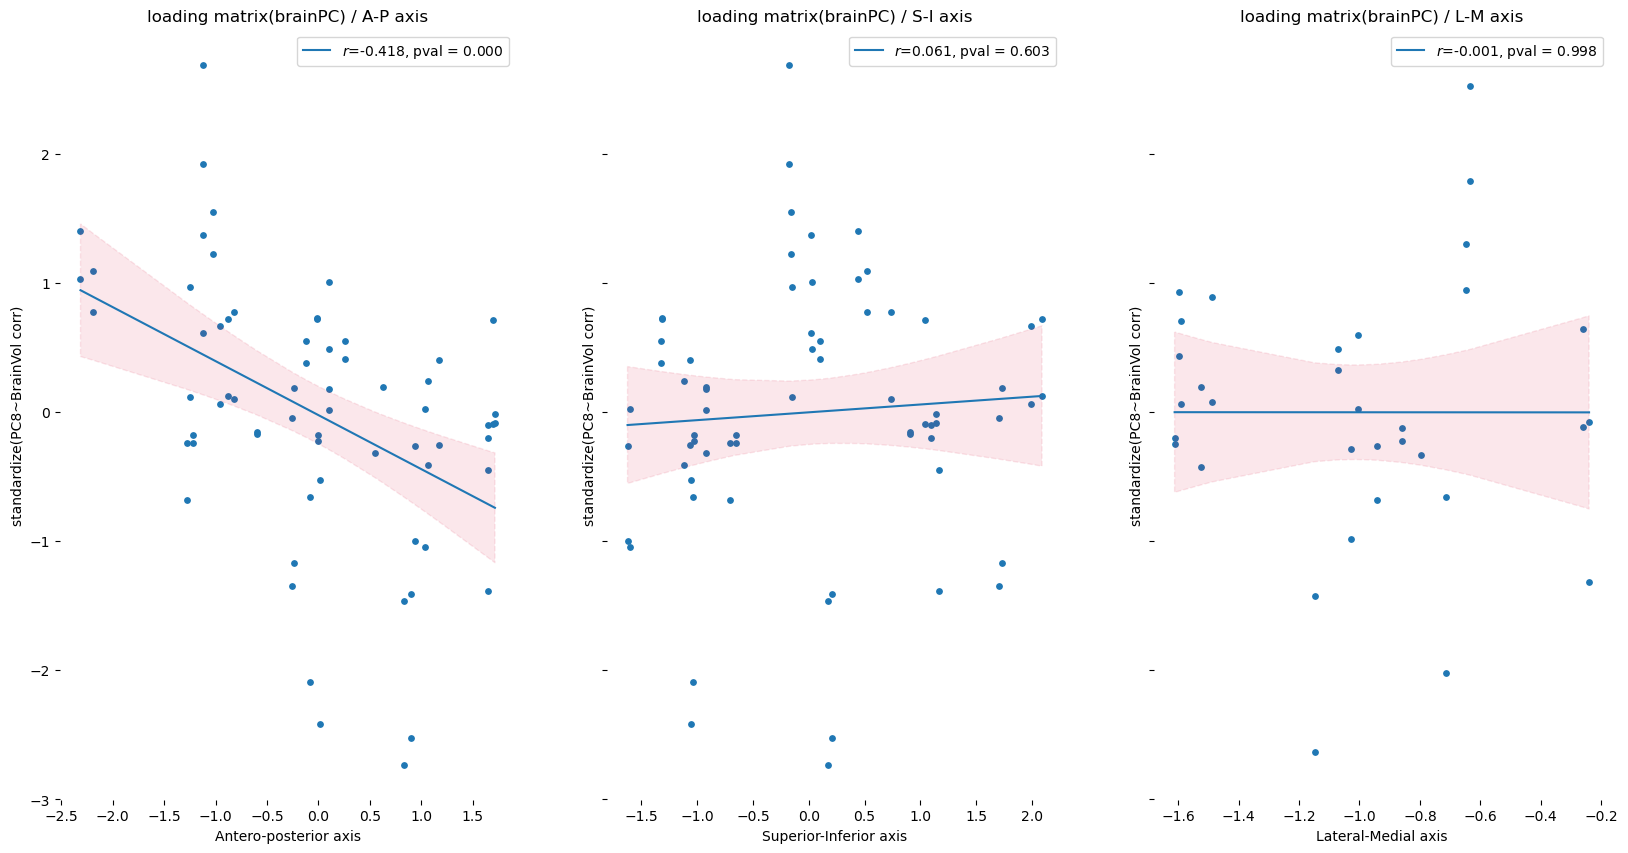

In [207]:
pc=7
fig,axes = plt.subplots(1,3,figsize=(20,10),sharey=True)
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[brain_loading_matrix[pc].index,'Y'],
                                  y=brain_loading_matrix[pc], 
#                                   annotate=[Imperial_labels[i]['abbr'] for i in loading_matrix.index],
                                  ylabel='PC8~BrainVol corr', 
                                  xlabel='Antero-posterior axis',scaling='y',return_stats=True,legend=True,title='loading matrix(brainPC) / A-P axis',ax=axes[0],
                                 legend_loc='upper right',markersize=15)
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[brain_loading_matrix[pc].index,'Z'],
                                  y=brain_loading_matrix[pc], 
#                                   annotate=[Imperial_labels[i]['abbr'] for i in loading_matrix.index],
                                  ylabel='PC8~BrainVol corr', 
                                  xlabel='Superior-Inferior axis',scaling='y',return_stats=True, legend=True,title='loading matrix(brainPC) / S-I axis',ax=axes[1],
                                 legend_loc='upper right',markersize=15)
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[data_preprocessing.Volumes.Imperial.get_segment(pd.DataFrame(brain_loading_matrix[pc]),col='index',side=['left']).index,'X'],
                                  y=data_preprocessing.Volumes.Imperial.get_segment(pd.DataFrame(brain_loading_matrix[pc]),col='index',side=['left'])[pc], 
#                                   annotate=[Imperial_labels[i]['abbr'] for i in data_preprocessing.Volumes.Imperial.get_segment(pd.DataFrame(loading_matrix[pc]),col='index',side=['left']).index],
                                  ylabel='PC8~BrainVol corr', 
                                  xlabel='Lateral-Medial axis',scaling='y',return_stats=True, legend=True,title='loading matrix(brainPC) / L-M axis',ax=axes[2],
                                 legend_loc='upper right',markersize=15)
sns.despine(bottom=True,right=True,left=True,top=True)

<AxesSubplot:xlabel='standardize(Adj. PRS_pca)', ylabel='standardize(Adj. Brain-PC8)'>

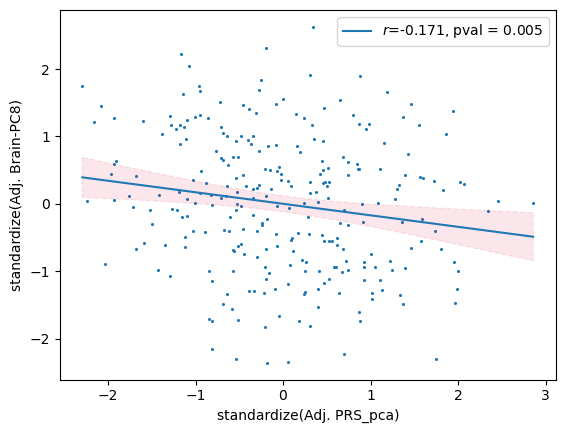

In [30]:
visualisation.SimplePlots.Scatter(x='PRS_pca',
                                 y=brain_pca[:,7],adjust_covar={'x':ancestry,'y':['GA','PMA','sex','TBV']},
                                  ylabel='Brain-PC8',
                                 data=df,legend_loc='upper right')

In [32]:
stats.MassUnivariate.calculate_R_squared_explained(df,
                                                   cat_independentVar_cols=['sex'],
                                                    cont_independentVar_cols=['PRS_pca','GA','PMA','TBV']+ancestry,
                                                    dependentVar_cols=brain_pca[:,7],
                                                   cols_to_drop=['PRS_pca'])

0.050444634515580455

In [298]:
#brain_pca_mass_univariate.sort_values(by="standardize(Q('PRS_pca'))_pval")

### individual regions

In [213]:
groupings = ['lobe','hemisphere']

In [214]:
new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=groupings)

In [208]:
data_preprocessing.Volumes.Imperial.get_segment(df,'column',lobe=['frontal','temporal','occipital','parietal'])

,Imperial 11,Imperial 12,Imperial 13,Imperial 14,Imperial 15,Imperial 16,Imperial 22,Imperial 23,Imperial 26,Imperial 27,...,Imperial 70,Imperial 71,Imperial 72,Imperial 73,Imperial 74,Imperial 79,Imperial 8,Imperial 80,Imperial 81,Imperial 82
0,3311.875,3682.625,3078.250,3047.250,819.125,716.750,14354.125,14365.125,1333.000,1329.125,...,1098.125,4095.125,3431.750,1377.375,1233.500,30746.625,1289.000,31885.250,17655.250,18321.125
1,2907.375,3253.125,2840.250,3453.625,891.500,872.875,12730.625,13736.750,1277.125,1371.750,...,1377.375,3812.750,3829.625,1416.000,1034.875,31199.875,1239.625,31325.250,19057.500,19708.250
2,3365.375,2760.000,2435.500,2778.000,777.375,724.125,12095.625,11564.250,1034.875,1018.375,...,1245.875,4122.000,3357.625,1366.500,1154.500,29957.875,969.125,30724.500,18579.875,18492.750
3,2851.625,2934.375,2654.375,2835.750,700.500,817.500,12671.625,12887.125,1082.500,1029.875,...,922.125,3823.750,3500.125,1194.500,966.875,26685.875,920.375,26491.500,14771.000,15374.375
4,2645.250,2685.875,2296.375,2414.250,656.250,632.125,9992.375,10344.500,860.875,750.375,...,917.375,3332.125,3567.750,1181.750,840.750,27601.375,935.250,27113.125,16961.250,17521.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,3444.375,3690.875,2769.750,2992.250,759.500,956.250,15214.500,16404.625,1415.625,1362.125,...,1233.250,4208.250,4045.875,1521.000,1313.875,31456.375,1047.000,32061.875,18396.500,17962.375
269,3205.000,3498.750,2831.125,3328.125,729.625,989.125,12406.750,12574.375,1504.625,1409.500,...,1487.625,4613.500,4679.250,1402.500,1053.500,34904.750,1033.375,35141.375,20250.250,20490.875
270,3149.375,3462.375,2712.625,3447.000,712.125,829.500,11942.625,13025.500,981.250,1318.875,...,1405.250,3813.875,3400.750,1308.500,1269.625,32809.750,1139.250,34135.750,18273.250,17223.000
271,3265.125,3064.750,3105.000,2589.625,894.750,896.625,15454.500,13508.625,1141.500,1093.500,...,1264.500,4382.250,3344.625,2000.125,1549.125,34623.125,860.750,35150.500,17778.625,18880.375


In [185]:
new_df['Frontal lobe TTV'] = new_df['Imperial 36']
new_df['Parietal lobe TTV'] = new_df['Imperial 38']
new_df['Occipital lobe TTV'] = new_df['Imperial 15']
new_df['Temporal lobe TTV'] = new_df['Imperial 5']

# new_df['Frontal+Parietal TTV'] = new_df['Frontal lobe TTV'] + new_df['Parietal lobe TTV']
# new_df['Frontal+Occipital TTV'] = new_df['Frontal lobe TTV'] + new_df['Occipital lobe TTV']
new_df['Frontal+Temporal TTV'] = new_df['Frontal lobe TTV'] + new_df['Temporal lobe TTV']
new_df['Parietal+Occipital TTV'] = new_df['Parietal lobe TTV'] + new_df['Occipital lobe TTV']
# new_df['Parietal+Temporal TTV'] = new_df['Parietal lobe TTV'] + new_df['Temporal lobe TTV']
# new_df['Occipital+Temporal TTV'] = new_df['Temporal lobe TTV'] + new_df['Occipital lobe TTV']


In [216]:
[(data_preprocessing.Volumes.Imperial.get_Imperial_legends()[i]['abbr'],i) for i in new_df.columns if 'Imperial' in i]

[('ATL.GM.left.medial', 'Imperial 5'),
 ('LOG.GM.left.anterior', 'Imperial 15'),
 ('FL.GM.right', 'Imperial 36'),
 ('PL.GM.right', 'Imperial 38'),
 ('ATL.WM.left.medial', 'Imperial 51'),
 ('LOG.WM.left.anterior', 'Imperial 61'),
 ('FL.WM.right', 'Imperial 79'),
 ('PL.WM.right', 'Imperial 81')]

In [217]:
new_df['Parietal lobe GM TTV'] = new_df['Imperial 38']
new_df['Parietal lobe WM TTV'] = new_df['Imperial 81']

new_df['Frontal lobe GM TTV'] = new_df['Imperial 36']
new_df['Frontal lobe WM TTV'] = new_df['Imperial 79']

new_df['Occipital lobe GM TTV'] = new_df['Imperial 15']
new_df['Occipital lobe WM TTV'] = new_df['Imperial 61']

new_df['Temporal lobe GM TTV'] = new_df['Imperial 5']
new_df['Temporal lobe WM TTV'] = new_df['Imperial 51']

# new_df['Parietal TTV'] = new_df['Parietal lobe GM TTV'] + new_df['Parietal lobe WM TTV']
# new_df['Occipital TTV'] = new_df['Occipital lobe GM TTV'] + new_df['Occipital lobe WM TTV']
# new_df['Temporal TTV'] = new_df['Temporal lobe GM TTV'] + new_df['Temporal lobe WM TTV']
# new_df['Frontal TTV'] = new_df['Frontal lobe GM TTV'] + new_df['Frontal lobe WM TTV']

new_df['F+T GM TTV'] = new_df['Frontal lobe GM TTV'] + new_df['Temporal lobe GM TTV']
new_df['F+T WM TTV'] = new_df['Frontal lobe WM TTV'] + new_df['Temporal lobe WM TTV']

new_df['P+O GM TTV'] = new_df['Parietal lobe GM TTV'] + new_df['Occipital lobe GM TTV']
new_df['P+O WM TTV'] = new_df['Parietal lobe WM TTV'] + new_df['Occipital lobe WM TTV']

# new_df['F+T TTV'] = new_df['F+T GM TTV'] + new_df['F+T WM TTV']
# new_df['P+O TTV'] = new_df['P+O GM TTV'] + new_df['P+O WM TTV']



In [150]:
new_df['Parietal lobe GM R TTV'] = new_df['Imperial 38']
new_df['Parietal lobe GM L TTV'] = new_df['Imperial 39']

new_df['Parietal lobe WM R TTV'] = new_df['Imperial 81']
new_df['Parietal lobe WM L TTV'] = new_df['Imperial 82']

new_df['Occipital lobe GM R TTV'] = new_df['Imperial 16']
new_df['Occipital lobe GM L TTV'] = new_df['Imperial 15']

new_df['Occipital lobe WM R TTV'] = new_df['Imperial 62']
new_df['Occipital lobe WM L TTV'] = new_df['Imperial 61']

new_df['P+O lobe WM R TTV'] = new_df['Imperial 81'] + new_df['Imperial 62']
new_df['P+O lobe WM L TTV'] = new_df['Imperial 82'] + new_df['Imperial 61']

new_df['P+O lobe GM R TTV'] = new_df['Imperial 38'] + new_df['Imperial 16']
new_df['P+O lobe GM L TTV'] = new_df['Imperial 39'] + new_df['Imperial 15']


new_df['Frontal lobe GM R TTV'] = new_df['Imperial 36']
new_df['Frontal lobe GM L TTV'] = new_df['Imperial 37']

new_df['Frontal lobe WM R TTV'] = new_df['Imperial 79']
new_df['Frontal lobe WM L TTV'] = new_df['Imperial 80']

new_df['Temporal lobe GM R TTV'] = new_df['Imperial 6']
new_df['Temporal lobe GM L TTV'] = new_df['Imperial 5']

new_df['Temporal lobe WM R TTV'] = new_df['Imperial 52']
new_df['Temporal lobe WM L TTV'] = new_df['Imperial 51']

new_df['F+T lobe WM R TTV'] = new_df['Imperial 79'] + new_df['Imperial 52']
new_df['F+T lobe WM L TTV'] = new_df['Imperial 80'] + new_df['Imperial 51']

new_df['F+T lobe GM R TTV'] = new_df['Imperial 36'] + new_df['Imperial 6']
new_df['F+T lobe GM L TTV'] = new_df['Imperial 37'] + new_df['Imperial 5']

new_df['Parietal R TTV'] = new_df['Parietal lobe GM R TTV'] + new_df['Parietal lobe WM R TTV']
new_df['Parietal L TTV'] = new_df['Parietal lobe GM L TTV'] + new_df['Parietal lobe WM L TTV']
new_df['Parietal TTV'] = new_df['Parietal R TTV'] + new_df['Parietal L TTV']

new_df['Occipital R TTV'] = new_df['Occipital lobe GM R TTV'] + new_df['Occipital lobe WM R TTV']
new_df['Occipital L TTV'] = new_df['Occipital lobe GM L TTV'] + new_df['Occipital lobe WM L TTV']
new_df['Occipital TTV'] = new_df['Occipital R TTV'] + new_df['Occipital L TTV']

new_df['Temporal R TTV'] = new_df['Temporal lobe GM R TTV'] + new_df['Temporal lobe WM R TTV']
new_df['Temporal L TTV'] = new_df['Temporal lobe GM L TTV'] + new_df['Temporal lobe WM L TTV']
new_df['Temporal TTV'] = new_df['Temporal R TTV'] + new_df['Temporal L TTV']

new_df['Frontal R TTV'] = new_df['Frontal lobe GM R TTV'] + new_df['Frontal lobe WM R TTV']
new_df['Frontal L TTV'] = new_df['Frontal lobe GM L TTV'] + new_df['Frontal lobe WM L TTV']
new_df['Frontal TTV'] = new_df['Frontal R TTV'] + new_df['Frontal L TTV']

new_df['F+T R TTV'] = new_df['Frontal R TTV'] + new_df['Temporal R TTV']
new_df['F+T L TTV'] = new_df['Frontal L TTV'] + new_df['Temporal L TTV']
new_df['F+T TTV'] = new_df['F+T R TTV'] + new_df['F+T L TTV']

new_df['P+O R TTV'] = new_df['Parietal R TTV'] + new_df['Occipital R TTV']
new_df['P+O L TTV'] = new_df['Parietal L TTV'] + new_df['Occipital L TTV']
new_df['P+O TTV'] = new_df['P+O R TTV'] + new_df['P+O L TTV']





In [149]:
# new_df['Frontal lobe'] = new_df['Imperial 36']
# new_df['Parietal lobe'] = new_df['Imperial 38']
# new_df['Occipital lobe'] = new_df['Imperial 15']
# new_df['Temporal lobe'] = new_df['Imperial 5']

# # new_df['Frontal+Parietal TTV'] = new_df['Frontal lobe TTV'] + new_df['Parietal lobe TTV']
# # new_df['Frontal+Occipital TTV'] = new_df['Frontal lobe TTV'] + new_df['Occipital lobe TTV']
# new_df['Frontal+Temporal TTV'] = new_df['Frontal lobe TTV'] + new_df['Temporal lobe TTV']
# new_df['Parietal+Occipital TTV'] = new_df['Parietal lobe TTV'] + new_df['Occipital lobe TTV']
# # new_df['Parietal+Temporal TTV'] = new_df['Parietal lobe TTV'] + new_df['Temporal lobe TTV']
# # new_df['Occipital+Temporal TTV'] = new_df['Temporal lobe TTV'] + new_df['Occipital lobe TTV']


In [218]:
_, european_mass_univariate = stats.MassUnivariate.mass_univariate(new_df,
                                     cat_independentVar_cols=['sex'],
                                     cont_independentVar_cols=['PRS_pca','PMA','GA','TBV']+ancestry,
                                     dependentVar_cols=[i for i in new_df.columns if 'TTV' in i])

In [222]:
[i for i in new_df.columns if 'PRS' in i]

['SCZ_PRS_Pt_1e-08',
 'SCZ_PRS_Pt_1e-07',
 'SCZ_PRS_Pt_1e-06',
 'SCZ_PRS_Pt_1e-05',
 'SCZ_PRS_Pt_0.0001',
 'SCZ_PRS_Pt_0.001',
 'SCZ_PRS_Pt_0.01',
 'SCZ_PRS_Pt_0.05',
 'SCZ_PRS_Pt_0.1',
 'SCZ_PRS_Pt_0.5',
 'SCZ_PRS_Pt_1',
 'ASD_PRS_Pt_1e-08',
 'ASD_PRS_Pt_1e-06',
 'ASD_PRS_Pt_1e-05',
 'ASD_PRS_Pt_0.0001',
 'ASD_PRS_Pt_0.001',
 'ASD_PRS_Pt_0.01',
 'ASD_PRS_Pt_0.05',
 'ASD_PRS_Pt_0.1',
 'ASD_PRS_Pt_0.5',
 'ASD_PRS_Pt_1',
 'PRS_pca']

In [194]:
european_mass_univariate = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    new_df,
    thresholds=[i for i in new_df.columns if 'ASD_PRS' in i],
                                     cat_independentVar_cols=['sex'],
                                     cont_independentVar_cols=['PMA','GA','TBV']+ancestry,
                                     dependentVar_cols=[i for i in new_df.columns if 'TTV' in i])

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.47it/s]


In [219]:
european_mass_univariate.sort_values(by='PRS_pval')

KeyError: 'PRS_pval'

In [220]:
european_mass_univariate.sort_values(by="standardize(Q('PRS_pca'))_pval")

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
F+T GM TTV,79749.643182,0.000000e+00,-317.966745,0.281692,331.568760,0.013221,2564.100056,1.249322e-20,115.179272,0.498282,11353.377553,6.487826e-140,17.393760,0.897393,-105.479463,0.431298,116.413674,0.386396
P+O WM TTV,53410.638132,0.000000e+00,1089.802940,0.000231,-315.853471,0.017108,-2335.449541,4.522952e-18,-130.701110,0.437836,7430.282311,1.044331e-98,-19.288537,0.885186,137.368541,0.300922,-5.585956,0.966501
Frontal lobe GM TTV,53548.100940,0.000000e+00,-323.722752,0.203192,247.966870,0.031130,1506.283912,3.389585e-11,146.590211,0.317025,7771.641086,1.508692e-116,104.592497,0.368108,-49.248643,0.669398,141.735051,0.220928
Parietal lobe WM TTV,35017.936697,1.801392e-297,543.945747,0.025841,-210.079054,0.055984,-1561.469833,9.611974e-13,10.336171,0.941138,4601.765836,7.564910e-73,-73.385771,0.508919,106.493031,0.334699,-81.810211,0.459649
Parietal lobe GM TTV,38557.130375,0.000000e+00,-452.728357,0.029775,-165.979916,0.076813,1701.974417,7.660608e-19,211.246136,0.078004,4960.096715,4.955659e-93,-10.416602,0.912521,133.936136,0.155712,-63.513490,0.501305
P+O GM TTV,67205.225530,0.000000e+00,-731.612138,0.029370,-246.038004,0.103538,2502.648998,2.822542e-16,435.065561,0.024605,8957.331658,1.237612e-103,-51.282620,0.737251,131.999497,0.384848,-68.520707,0.652602
Occipital lobe WM TTV,18392.701436,8.365232e-283,545.857192,0.000206,-105.774417,0.106892,-773.979709,1.891121e-09,-141.037281,0.092572,2828.516475,3.480396e-75,54.097234,0.415157,30.875510,0.639437,76.224255,0.249182
Temporal lobe GM TTV,26201.542242,4.828009e-320,5.756007,0.969214,83.601889,0.214498,1057.816144,6.288766e-15,-31.410939,0.714774,3581.736468,2.056804e-93,-87.198737,0.201629,-56.230819,0.406609,-25.321377,0.709209
F+T WM TTV,84461.625830,0.000000e+00,601.823345,0.105010,202.404217,0.226136,-4726.572694,7.717372e-37,-24.060900,0.910228,11581.391370,1.007731e-118,-4.686132,0.977918,-336.585202,0.046121,92.781100,0.582174
Frontal lobe WM TTV,60213.832785,0.000000e+00,483.331400,0.129812,172.832165,0.229267,-3556.209345,2.512274e-30,15.408242,0.933065,8524.661657,1.414229e-103,12.770625,0.930081,-273.016331,0.059775,108.828743,0.452935


In [199]:
0.05/18

0.002777777777777778

In [221]:
stats.matSpDLite(np.corrcoef(new_df[[i for i in new_df.columns if 'TTV' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 4.225330266138099
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 3.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.01666666666666666


3.0000000000000013

In [229]:
adjusted_df = stats.MassUnivariate.adjust_covariates_with_lin_reg(new_df,
                                                                 cat_independentVar_cols=['sex'],
                                                                 cont_independentVar_cols=['GA','PMA','TBV'],
                                                                dependentVar_cols=data_preprocessing.Volumes.Imperial.get_segment(new_df,col='column',lobe=['occipital','temporal','frontal','parietal']))

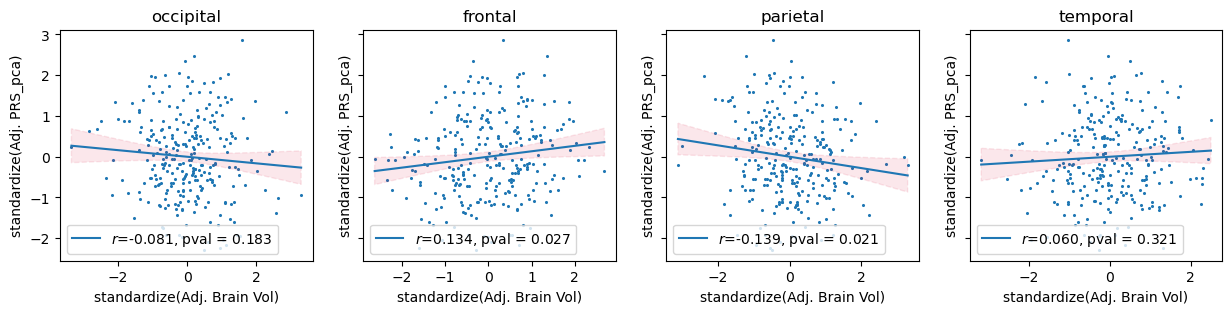

In [230]:
fig,axes = plt.subplots(1,4,figsize=(15,3),sharey=True)
for (idx,ax),name in zip(enumerate(axes.flatten()),['occipital','frontal','parietal','temporal']):
    visualisation.SimplePlots.Scatter(x=adjusted_df.values[:,idx],
                                     y = prs_pca,adjust_covar={'y':ancestry},data = new_df,ax=ax,legend_loc='lower left',title=name,ylabel='PRS_pca', xlabel='Adj. Brain Vol')

In [154]:
from statsmodels.stats.multitest import fdrcorrection

In [192]:
survived, fdrpval = fdrcorrection(european_mass_univariate["standardize(Q('PRS_pca'))_pval"].values,method='p',alpha=0.05)

In [193]:
european_mass_univariate[survived]

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval


In [34]:
ancestry = [f'euro_Anc_PC{i}' for i in range(1,4)]

In [318]:
_, european_mass_univariate = stats.MassUnivariate.mass_univariate(
    new_df,
    dependentVar_cols=[i for i in new_df.columns if 'TTV' in i],
    formula='standardize(PRS_pca)+C(sex)+standardize(PMA)+standardize(GA)+standardize(TBV)'+'+'+'+'.join(ancestry))

In [319]:
european_mass_univariate.sort_values(by='standardize(PRS_pca)_pval')

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(PRS_pca)_coef,standardize(PRS_pca)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval
Frontal+Temporal TTV,164192.620315,0.000000e+00,272.097576,0.513652,543.390567,0.004063,-2156.483174,4.862578e-09,92.356443,0.700127,22930.757798,1.972350e-178,313.066979,0.937405,-10419.061575,0.020254,6552.622768,0.255498
Parietal+Occipital TTV,119061.170430,0.000000e+00,364.697200,0.420343,-567.108117,0.005738,98.257662,7.997609e-01,323.042869,0.215469,16186.253176,1.644450e-132,-1708.044931,0.693276,6214.694712,0.200726,-2814.182453,0.652654
Parietal lobe TTV,73583.078956,0.000000e+00,99.790300,0.782615,-383.955501,0.019088,136.482335,6.595051e-01,220.566148,0.289992,9564.564420,1.641730e-102,-1791.496100,0.604931,5664.413217,0.144887,-4552.740820,0.362769
Frontal lobe TTV,113750.432960,0.000000e+00,147.091474,0.726462,442.319002,0.020185,-2047.390661,3.333517e-08,164.582758,0.496741,16294.513962,8.728780e-141,2525.407861,0.530500,-7630.230611,0.091388,7757.155196,0.182623
Parietal+Temporal TTV,124025.266312,0.000000e+00,224.796403,0.605588,-282.883936,0.149983,27.389822,9.414189e-01,148.339832,0.554003,16200.808257,1.399742e-136,-4003.836982,0.336992,2875.582253,0.537900,-5757.273248,0.338943
Occipital lobe TTV,45478.091474,1.611150e-304,264.906899,0.372039,-183.152616,0.171243,-38.224673,8.803566e-01,102.476721,0.548509,6621.688756,5.831812e-87,83.451169,0.976548,550.281495,0.862601,1738.558367,0.671485
Frontal+Occipital TTV,159228.524434,0.000000e+00,411.998373,0.335678,259.166386,0.179324,-2085.615334,3.176991e-08,267.059479,0.278542,22916.202718,1.784366e-175,2608.859030,0.524049,-7079.949116,0.123353,9495.713563,0.108957
Temporal lobe TTV,50442.187356,0.000000e+00,125.006102,0.620200,101.071566,0.374149,-109.092513,6.135586e-01,-72.226315,0.618980,6636.243836,4.924393e-102,-2212.340882,0.359862,-2788.830965,0.302861,-1204.532428,0.729697
Occipital+Temporal TTV,95920.278830,0.000000e+00,389.913002,0.268864,-82.081050,0.605155,-147.317186,6.253658e-01,30.250406,0.881431,13257.932592,9.887580e-138,-2128.889713,0.527978,-2238.549470,0.553503,534.025939,0.912655
Frontal+Parietal TTV,187333.511916,0.000000e+00,246.881774,0.556273,58.363500,0.757509,-1910.908326,2.164236e-07,385.148906,0.111625,25859.078382,7.645081e-191,733.911761,0.854985,-1965.817393,0.662102,3204.414376,0.580563


In [165]:
new_df[['ID','ID','Frontal+Temporal TTV']].to_csv('../../codes/gene_set/PRSice/output/asd/asd_phenotype.txt',header=['FID','IID','FTvol'],index=False,sep='\t')

In [155]:
new_df['sex']=[1 if i=='female' else 0 for i in new_df['sex']]

In [166]:
new_df[['ID','ID','TBV','GA','PMA','sex']+ancestry].to_csv('../../codes/gene_set/PRSice/output/asd/asd_covariates.txt',header=['FID','IID','TBV','GA','PMA','sex']+ancestry,index=False,sep='\t')

In [144]:
stats.matSpDLite(np.corrcoef(new_df[[i for i in new_df.columns if 'ASD' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 57.54926470402535
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 17.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0029411764705882374


16.99999999999999

In [30]:
ROIs_coord_Imperial = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/Imperial/atlas_t40.nii.gz')
ROIs_coord_Imperial['Label'] = [f'Imperial {int(i)}' for i in ROIs_coord_Imperial['Label']]

new_ROIs_coord_Imperial = ROIs_coord_Imperial.set_index('Label').T.copy()
new_ROIs_coord_Imperial = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(new_ROIs_coord_Imperial,grouping=['gmwm2gether'],operation='mean',drop_duplicates=False).T
new_ROIs_coord_Imperial = new_ROIs_coord_Imperial.drop([i for i in new_ROIs_coord_Imperial.index if not bool(re.search('Imperial \d',i))])

standardized_ROIs_coord = new_ROIs_coord_Imperial.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(new_ROIs_coord_Imperial[['X_vox','Y_vox','Z_vox']])

Imperial_labels = data_preprocessing.Volumes.Imperial.get_Imperial_legends(grouping='')

In [127]:
pca.explained_variance_ratio_

array([0.56892168, 0.04801913, 0.04242798, 0.0308735 , 0.02493798,
       0.02218366, 0.02018221, 0.01715463, 0.01640817, 0.0153342 ])

In [168]:
european_mass_univariate_group.sort_values(by="standardize(Q('PRS_pca'))_pval")

,corr_Z_coef,corr_Z_pval,corr_Y_coef,corr_Y_pval,corr_X_coef,corr_X_pval,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,...,standardize(GA)_coef,standardize(GA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
Brain_PC2,-0.622211,1.902097e-08,0.364510,0.002425,-0.059972,0.629744,0.201834,0.352036,-0.400742,0.215790,...,-0.279647,0.132654,-0.114730,6.263117e-01,-0.118341,0.439254,-0.108425,0.475735,0.000914,0.995205
Brain_PC7,0.096278,4.383132e-01,-0.239881,0.050559,-0.004608,0.970480,0.215033,0.117583,-0.426949,0.037838,...,0.029383,0.801628,0.026067,8.608950e-01,-0.175922,0.070154,0.053754,0.575456,-0.074401,0.439001
Brain_PC5,-0.134772,2.768766e-01,0.208391,0.090591,-0.013754,0.912040,0.087902,0.573446,-0.174529,0.453609,...,0.055698,0.676486,-0.044287,7.941852e-01,0.158190,0.152581,0.246512,0.025738,-0.033564,0.759414
Brain_PC1,-0.036090,7.718597e-01,-0.047644,0.701823,0.021892,0.860419,0.066527,0.638724,-0.132089,0.531944,...,-0.035724,0.768083,-1.350569,8.810245e-15,-0.138412,0.167817,-0.103858,0.296934,-0.098256,0.324160
Brain_PC4,-0.259476,3.397251e-02,0.020545,0.868928,0.097294,0.433477,0.256467,0.130411,-0.509217,0.044706,...,0.063708,0.659103,0.111223,5.450011e-01,-0.026643,0.823086,-0.065497,0.580424,0.032034,0.787017
Brain_PC3,0.324357,7.410034e-03,-0.095846,0.440382,0.101009,0.416036,-0.064213,0.731879,0.127494,0.648229,...,0.268556,0.095525,0.190132,3.517124e-01,-0.092607,0.484220,0.109058,0.407329,-0.069703,0.596491
Brain_PC9,0.319799,8.337804e-03,0.276007,0.023771,-0.164500,0.183441,0.101930,0.433229,-0.202382,0.297077,...,-0.131678,0.237185,-0.035822,7.999100e-01,0.150612,0.102283,0.178022,0.052490,0.095060,0.298436
Brain_PC8,0.049763,6.892200e-01,0.106914,0.389167,0.005167,0.966902,0.114944,0.394116,-0.228223,0.256933,...,-0.239072,0.039553,-0.013556,9.262859e-01,0.138858,0.145816,0.009490,0.919994,0.060116,0.525386
Brain_PC6,0.019733,8.740659e-01,-0.216245,0.078817,-0.268685,0.027914,-0.278189,0.066120,0.552346,0.014891,...,-0.176783,0.170816,-0.254084,1.221201e-01,0.008379,0.937088,0.004704,0.964434,-0.006820,0.948508
Brain_PC0,-0.464868,7.394199e-05,-0.050728,0.683514,-0.103548,0.404352,-0.022203,0.863405,0.044085,0.818783,...,0.082392,0.455804,-6.361524,8.665987e-81,-0.053164,0.559732,-0.051174,0.572121,-0.053391,0.556034


In [171]:
european_mass_univariate_group

,corr_Z_coef,corr_Z_pval,corr_Y_coef,corr_Y_pval,corr_X_coef,corr_X_pval,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,...,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,group,random_state
Brain_PC2,-0.622211,1.902097e-08,0.36451,0.002425,-0.059972,0.629744,0.201834,0.352036,-0.400742,0.21579,...,-0.11473,0.626312,-0.118341,0.439254,-0.108425,0.475735,0.000914,0.995205,1,2


In [19]:
new_df = data_preprocessing.Volumes.Imperial.get_segment(df,'column',tissue=['WM','GM'])
new_df = new_df.drop(columns='Imperial 48')
new_df = pd.concat([new_df,df[['Imperial 3','Imperial 4']]],axis=1)

In [20]:
import os

In [58]:
random_run = pd.DataFrame()
for random_state in tqdm(range(1000)):
    groups = stats.Stability_tests.split_group(df,stratify_by_args=['GA','PMA','TBV'],n=2,bins=4)
    for gr_idx,group in enumerate(groups):
        new_df_group = new_df.iloc[group.index]
        pca, prs_pca, prs_loading_matrix = stats.FeatureReduction.perform_PCA(
                group,
                dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
                scaling=True,
                n_components=1)
        
        group['PRS_pca'] = prs_pca
        
        pca, brain_prs_pca, brain_loading_matrix = stats.FeatureReduction.perform_PCA(
                new_df_group,
                dependentVar_cols=new_df_group.columns.tolist(),
                scaling=True,
                n_components=.8
        )
        
        group[[f'Brain_PC{i}' for i in range(brain_prs_pca.shape[1])]] = brain_prs_pca
        brain_loading_matrix.columns = [f'Brain_PC{i}' for i in range(brain_prs_pca.shape[1])]
        
        _, european_mass_univariate_group = stats.MassUnivariate.mass_univariate(
                group,
                cat_independentVar_cols=['sex'],
                cont_independentVar_cols=['PRS_pca','PMA','GA','TBV']+ancestry,
                dependentVar_cols=[i for i in group.columns if 'Brain_PC' in i])
        
        for direction in ['X','Y','Z']:
            brain_corr = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
                    brain_loading_matrix,
                    thresholds=brain_loading_matrix.columns,
                    threshold_prefix=f'corr_{direction}',
                    dependentVar_cols=standardized_ROIs_coord.loc[brain_loading_matrix.index,direction],
                    fit_intercept=False,scaling='both',disable_tqdm=True)

            brain_corr = brain_corr.set_index('threshold')[[f'corr_{direction}_coef',f'corr_{direction}_pval']]
            european_mass_univariate_group = pd.concat([brain_corr,european_mass_univariate_group],axis=1)
        european_mass_univariate_group = european_mass_univariate_group[european_mass_univariate_group["corr_Y_pval"]<0.05]
        
#         european_mass_univariate_group = european_mass_univariate_group.sort_values(by="standardize(Q('PRS_pca'))_pval").head(1)
        
        european_mass_univariate_group['group'] = gr_idx
        european_mass_univariate_group['random_state'] = random_state
        test_file='stability_test_sort_by_Y.csv'
        european_mass_univariate_group.to_csv(test_file,mode='a',header=not os.path.exists(test_file))
#         random_run = pd.concat([random_run,european_mass_univariate_group])
        
        

100%|███████████████████████████████████████| 1000/1000 [11:43<00:00,  1.42it/s]


In [59]:
random_run = pd.read_csv('stability_test_sort_by_Y.csv',index_col=0)

In [60]:
test = random_run[['corr_Z_pval','corr_X_pval','corr_Y_coef','corr_Y_pval',"standardize(Q('PRS_pca'))_coef","standardize(Q('PRS_pca'))_pval",'group','random_state']]

In [61]:
test = test[(test['corr_X_pval']>0.05)&(test['corr_Z_pval']>0.05)]

In [68]:
len([i for i in range(1000) if i in test.loc[test["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state'].values])

412

In [63]:
len([i for i in range(1000) if i in test.loc[test["corr_Y_pval"]<0.05,'random_state'].values])

994

In [64]:
test.groupby(test.index).count()

,corr_Z_pval,corr_X_pval,corr_Y_coef,corr_Y_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,group,random_state
Brain_PC1,1,1,1,1,1,1,1,1
Brain_PC10,6,6,6,6,6,6,6,6
Brain_PC2,9,9,9,9,9,9,9,9
Brain_PC3,53,53,53,53,53,53,53,53
Brain_PC4,202,202,202,202,202,202,202,202
Brain_PC5,408,408,408,408,408,408,408,408
Brain_PC6,695,695,695,695,695,695,695,695
Brain_PC7,711,711,711,711,711,711,711,711
Brain_PC8,429,429,429,429,429,429,429,429
Brain_PC9,108,108,108,108,108,108,108,108


In [39]:
len([i for i in range(1000) if (test.loc[test["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state']==i).sum()>1])

115

In [27]:
stats.Stability_tests.split_group(df,stratify_by_args=['GA','PMA','TBV'],fraction=.8)

,ID,Session,TBV,ICV,CSF,GM,WM,Background,Ventricles,Cerebellum,...,ASD_PRS_Pt_1e-06,ASD_PRS_Pt_1e-05,ASD_PRS_Pt_0.0001,ASD_PRS_Pt_0.001,ASD_PRS_Pt_0.01,ASD_PRS_Pt_0.05,ASD_PRS_Pt_0.1,ASD_PRS_Pt_0.5,ASD_PRS_Pt_1,PRS_pca
250,CC00664XX13,195200,282530.625000,347896.875000,61586.375000,110711.500000,123233.750000,44195.875000,3779.875000,19347.625000,...,0.005485,0.002611,-0.006472,-0.003451,-0.002279,-0.001733,-0.001624,-0.001097,-0.000852,-1.312710
45,CC00109XX10,36901,272966.750000,332837.625000,57201.125000,100389.250000,126212.125000,41058.500000,2669.750000,17330.875000,...,0.001790,0.012864,-0.004991,-0.003148,-0.002069,-0.001658,-0.001598,-0.001062,-0.000827,0.607130
152,CC00334XX13,106100,306112.625000,364790.625000,55473.875000,115185.250000,144473.625000,49710.250000,3204.125000,18181.000000,...,0.009901,0.009529,-0.003945,-0.002829,-0.001899,-0.001677,-0.001554,-0.001050,-0.000813,1.522911
246,CC00647XX21,190801,271798.000000,330336.875000,55060.000000,105279.000000,120068.375000,35996.500000,3478.875000,17926.250000,...,-0.005482,0.003582,-0.007785,-0.003947,-0.002174,-0.001758,-0.001630,-0.001081,-0.000833,-1.272191
131,CC00257XX10,84700,287663.125000,346466.500000,54807.875000,105063.750000,133435.750000,39247.000000,3995.500000,20202.625000,...,-0.002371,0.007181,-0.006536,-0.004432,-0.002299,-0.001771,-0.001693,-0.001122,-0.000866,-2.544050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,CC01023XX09,74030,397169.625000,471289.625000,68000.250000,173366.125000,157319.750000,45446.250000,6119.750000,29157.875000,...,0.009534,0.010998,-0.004017,-0.001823,-0.001956,-0.001784,-0.001623,-0.001047,-0.000809,1.527887
205,CC01194XX16,149530,416077.850199,505136.719891,84711.869951,184599.363997,159745.615478,47752.622154,4346.999741,31104.623146,...,-0.002393,0.006455,-0.007741,-0.003203,-0.001923,-0.001518,-0.001405,-0.000959,-0.000738,3.817881
268,CC00685XX18,226100,425322.625000,535228.625000,101917.500000,190254.125000,163305.750000,44798.375000,7988.500000,30173.250000,...,-0.006987,0.000992,-0.009806,-0.004350,-0.002211,-0.001744,-0.001626,-0.001078,-0.000831,-1.660660
29,CC00799XX25,23810,476209.500000,562216.250000,80914.500000,208049.000000,192414.125000,55325.875000,5092.250000,32286.625000,...,-0.011271,-0.000756,-0.004978,-0.003558,-0.002277,-0.001882,-0.001759,-0.001111,-0.000860,-2.844312


In [105]:
groupings = ['gmwm2gether','lobe','hemisphere']

new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=groupings)

new_df['Frontal lobe TTV'] = new_df['Imperial 36']
new_df['Parietal lobe TTV'] = new_df['Imperial 38']
new_df['Occipital lobe TTV'] = new_df['Imperial 22']
new_df['Temporal lobe TTV'] = new_df['Imperial 5']

# new_df['Frontal+Parietal TTV'] = new_df['Frontal lobe TTV'] + new_df['Parietal lobe TTV']
# new_df['Frontal+Occipital TTV'] = new_df['Frontal lobe TTV'] + new_df['Occipital lobe TTV']
new_df['Frontal+Temporal TTV'] = new_df['Frontal lobe TTV'] + new_df['Temporal lobe TTV']
new_df['Parietal+Occipital TTV'] = new_df['Parietal lobe TTV'] + new_df['Occipital lobe TTV']
# new_df['Parietal+Temporal TTV'] = new_df['Parietal lobe TTV'] + new_df['Temporal lobe TTV']
# new_df['Occipital+Temporal TTV'] = new_df['Temporal lobe TTV'] + new_df['Occipital lobe TTV']


In [111]:
random_run = pd.DataFrame()
for random_state in tqdm(range(1000)):
    groups = stats.Stability_tests.split_group(df,stratify_by_args=['GA','PMA','TBV'],n=2,bins=4)
    for gr_idx,group in enumerate(groups):
        new_df_group = new_df.iloc[group.index]
        pca, prs_pca, prs_loading_matrix = stats.FeatureReduction.perform_PCA(
                group,
                dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
                scaling=True,
                n_components=1)
        
        group['PRS_pca'] = prs_pca
        
        _, european_mass_univariate_group = stats.MassUnivariate.mass_univariate(
                new_df_group,
                cat_independentVar_cols=['sex'],
                cont_independentVar_cols=['PRS_pca','PMA','GA','TBV']+ancestry,
                dependentVar_cols=['Frontal+Temporal TTV','Parietal+Occipital TTV'])
                
#         european_mass_univariate_group = european_mass_univariate_group.sort_values(by="standardize(Q('PRS_pca'))_pval").head(1)
        
        european_mass_univariate_group['group'] = gr_idx
        european_mass_univariate_group['random_state'] = random_state
        test_file='stability_test_regional_volume.csv'
        european_mass_univariate_group.to_csv(test_file,mode='a',header=not os.path.exists(test_file))
#         random_run = pd.concat([random_run,european_mass_univariate_group])
        
        

100%|███████████████████████████████████████| 1000/1000 [01:57<00:00,  8.54it/s]


In [113]:
random_run = pd.read_csv('stability_test_regional_volume.csv',index_col=0)

In [125]:
test1 = random_run.loc['Frontal+Temporal TTV',["standardize(Q('PRS_pca'))_pval",'group','random_state']]
test2 = random_run.loc['Parietal+Occipital TTV',["standardize(Q('PRS_pca'))_pval",'group','random_state']]

In [122]:
len([i for i in range(1000) if i in test1.loc[test1["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state'].values])

937

In [126]:
len([i for i in range(1000) if i in test2.loc[test2["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state'].values])

860

In [ ]:
len([i for i in range(1000) if i in test1.loc[test1["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state'].values])

In [139]:
_, count1 = np.unique(test1.loc[test1["standardize(Q('PRS_pca'))_pval"]<0.1,'random_state'].values,return_counts=True)
_, count2 = np.unique(test2.loc[test2["standardize(Q('PRS_pca'))_pval"]<0.1,'random_state'].values,return_counts=True)

In [140]:
len(count1[count1>1])

372

In [141]:
len(count2[count2>1])

259

In [65]:
random_run = pd.DataFrame()
for random_state in tqdm(range(1000)):
    groups = stats.Stability_tests.split_group(df,stratify_by_args=['GA','PMA','TBV'],fraction=.50).copy()
    for gr_idx,group in enumerate([groups]):
        new_df_group = new_df.iloc[group.index]
        pca, prs_pca, prs_loading_matrix = stats.FeatureReduction.perform_PCA(
                group,
                dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
                scaling=True,
                n_components=1)
        
        group['PRS_pca'] = prs_pca
        
        pca, brain_prs_pca, brain_loading_matrix = stats.FeatureReduction.perform_PCA(
                new_df_group,
                dependentVar_cols=new_df_group.columns.tolist(),
                scaling=True,
                n_components=.8
        )
        
        group[[f'Brain_PC{i}' for i in range(brain_prs_pca.shape[1])]] = brain_prs_pca
        brain_loading_matrix.columns = [f'Brain_PC{i}' for i in range(brain_prs_pca.shape[1])]
        
        _, european_mass_univariate_group = stats.MassUnivariate.mass_univariate(
                group,
                cat_independentVar_cols=['sex'],
                cont_independentVar_cols=['PRS_pca','PMA','GA','TBV']+ancestry,
                dependentVar_cols=[i for i in group.columns if 'Brain_PC' in i])
        
        for direction in ['X','Y','Z']:
            brain_corr = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
                    brain_loading_matrix,
                    thresholds=brain_loading_matrix.columns,
                    threshold_prefix=f'corr_{direction}',
                    dependentVar_cols=standardized_ROIs_coord.loc[brain_loading_matrix.index,direction],
                    fit_intercept=False,scaling='both',disable_tqdm=True)

            brain_corr = brain_corr.set_index('threshold')[[f'corr_{direction}_coef',f'corr_{direction}_pval']]
            european_mass_univariate_group = pd.concat([brain_corr,european_mass_univariate_group],axis=1)
        european_mass_univariate_group = european_mass_univariate_group[european_mass_univariate_group["corr_Y_pval"]<0.05]
        
#         european_mass_univariate_group = european_mass_univariate_group.sort_values(by="standardize(Q('PRS_pca'))_pval").head(1)
        
        european_mass_univariate_group['group'] = gr_idx
        european_mass_univariate_group['random_state'] = random_state
        test_file='stability_test_sort_by_Y_50per_removed.csv'
        european_mass_univariate_group.to_csv(test_file,mode='a',header=not os.path.exists(test_file))
        random_run = pd.concat([random_run,european_mass_univariate_group])
        
        

100%|███████████████████████████████████████| 1000/1000 [06:07<00:00,  2.72it/s]


In [66]:
test = random_run[['corr_Z_pval','corr_X_pval','corr_Y_coef','corr_Y_pval',"standardize(Q('PRS_pca'))_coef","standardize(Q('PRS_pca'))_pval",'group','random_state']]

test = test[(test['corr_X_pval']>0.05)&(test['corr_Z_pval']>0.05)]


In [67]:
len([i for i in range(1000) if i in test.loc[test["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state'].values])

154

In [68]:
len([i for i in range(1000) if i in test.loc[test["corr_Y_pval"]<0.05,'random_state'].values])

867

In [69]:
test

,corr_Z_pval,corr_X_pval,corr_Y_coef,corr_Y_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,group,random_state
Brain_PC7,0.126340,0.821542,0.604263,6.153556e-08,0.067429,0.500426,0,0
Brain_PC6,0.960655,0.191368,-0.247956,4.306040e-02,0.104553,0.329833,0,1
Brain_PC6,0.589417,0.267911,0.558550,9.026489e-07,0.186397,0.061250,0,2
Brain_PC5,0.816581,0.068173,0.253277,3.864000e-02,0.217954,0.038957,0,3
Brain_PC6,0.425692,0.760173,0.279677,2.189887e-02,0.184286,0.057179,0,3
...,...,...,...,...,...,...,...,...
Brain_PC8,0.539339,0.091770,0.434237,2.412054e-04,0.076592,0.415062,0,996
Brain_PC5,0.064442,0.936002,-0.318958,8.519664e-03,-0.092382,0.393818,0,997
Brain_PC7,0.227305,0.378929,-0.298560,1.412432e-02,-0.086295,0.383683,0,997
Brain_PC7,0.953500,0.403117,0.335863,5.458877e-03,0.055596,0.585452,0,998


In [71]:
new_df.sample(1,axis=1)

,Imperial 61
0,862.250
1,822.125
2,912.500
3,721.750
4,787.125
...,...
268,778.125
269,820.375
270,1004.625
271,1002.125


In [101]:
random_run = pd.DataFrame()
for random_state in tqdm(range(1000)):
    number_to_sample = np.random.choice([i for i in range(33,67)],1)[0]
    new_df_random = new_df.sample(number_to_sample,axis=1).copy()
    group = df.copy()
    pca, prs_pca, prs_loading_matrix = stats.FeatureReduction.perform_PCA(
            group,
            dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
            scaling=True,
            n_components=1)

    group['PRS_pca'] = prs_pca

    pca, brain_prs_pca, brain_loading_matrix = stats.FeatureReduction.perform_PCA(
            new_df_random,
            dependentVar_cols=new_df_random.columns.tolist(),
            scaling=True,
            n_components=.8
    )

    group[[f'Brain_PC{i}' for i in range(brain_prs_pca.shape[1])]] = brain_prs_pca
    brain_loading_matrix.columns = [f'Brain_PC{i}' for i in range(brain_prs_pca.shape[1])]

    _, european_mass_univariate_group = stats.MassUnivariate.mass_univariate(
            group,
            cat_independentVar_cols=['sex'],
            cont_independentVar_cols=['PRS_pca','PMA','GA','TBV']+ancestry,
            dependentVar_cols=[i for i in group.columns if 'Brain_PC' in i])

    for direction in ['X','Y','Z']:
        brain_corr = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
                brain_loading_matrix,
                thresholds=brain_loading_matrix.columns,
                threshold_prefix=f'corr_{direction}',
                dependentVar_cols=standardized_ROIs_coord.loc[brain_loading_matrix.index,direction],
                fit_intercept=False,scaling='both',disable_tqdm=True)

        brain_corr = brain_corr.set_index('threshold')[[f'corr_{direction}_coef',f'corr_{direction}_pval']]
        european_mass_univariate_group = pd.concat([brain_corr,european_mass_univariate_group],axis=1)
    european_mass_univariate_group = european_mass_univariate_group[european_mass_univariate_group["corr_Y_pval"]<0.05]

#         european_mass_univariate_group = european_mass_univariate_group.sort_values(by="standardize(Q('PRS_pca'))_pval").head(1)

    european_mass_univariate_group['removed'] = len(new_df.columns.tolist()) - number_to_sample
    european_mass_univariate_group['random_state'] = random_state
#     test_file='stability_test_sort_by_Y_50per_removed.csv'
#     european_mass_univariate_group.to_csv(test_file,mode='a',header=not os.path.exists(test_file))
    random_run = pd.concat([random_run,european_mass_univariate_group])



100%|███████████████████████████████████████| 1000/1000 [06:11<00:00,  2.69it/s]


In [102]:
test = random_run[['corr_Z_pval','corr_X_pval','corr_Y_coef','corr_Y_pval',"standardize(Q('PRS_pca'))_coef","standardize(Q('PRS_pca'))_pval",'removed','random_state']]

test = test[(test['corr_X_pval']>0.05)&(test['corr_Z_pval']>0.05)]

In [103]:
len([i for i in range(1000) if i in test.loc[test["standardize(Q('PRS_pca'))_pval"]<0.05,'random_state'].values])

451

In [104]:
len([i for i in range(1000) if i in test.loc[test["corr_Y_pval"]<0.05,'random_state'].values])

813

In [18]:
thresholds = [i for i in df.columns if 'ASD_PRS' in i]

In [60]:
all_combo = pd.DataFrame()
for threshold in thresholds:
    high_risk,low_risk = stats.Stability_tests.divide_high_low_risk(df[threshold],high_perc=0.4,low_perc=0.4)
    adjusted_df = stats.MassUnivariate.adjust_covariates_with_lin_reg(
        new_df,cat_independentVar_cols=['sex'],
        cont_independentVar_cols=['GA','PMA','TBV'],
        dependentVar_cols=['Frontal+Temporal TTV','Parietal+Occipital TTV'])
    adjusted_df['risk'] = ['high' if i in high_risk else 'low' if i in low_risk else np.nan for i in adjusted_df.index.tolist()]
    adjusted_df['threshold'] = threshold
    all_combo = pd.concat([all_combo,adjusted_df.dropna()])
all_combo = all_combo.reset_index(drop=True)

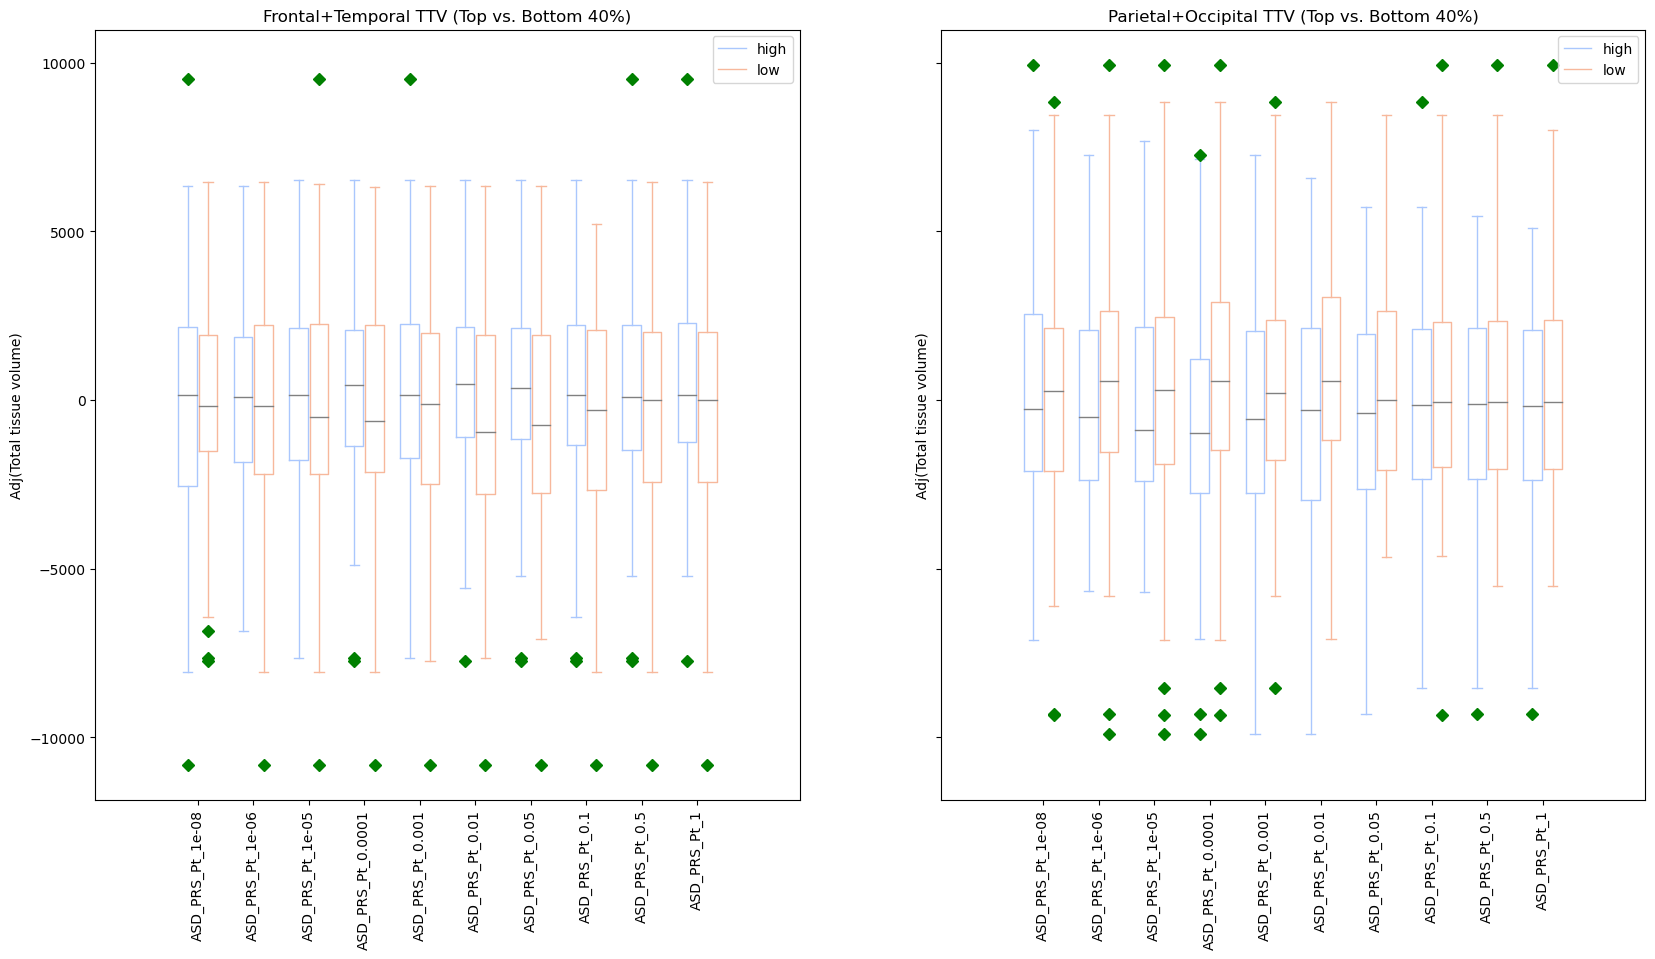

In [62]:
fig,axes = plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)
visualisation.SimplePlots.Box(x='threshold',
                              y='Frontal+Temporal TTV',
                              hue='risk',
                              data=all_combo,ylabel='Adj(Total tissue volume)',
                              ax=axes[0],
                              order=thresholds,rotation_x=90,title='Frontal+Temporal TTV (Top vs. Bottom 40%)')
visualisation.SimplePlots.Box(x='threshold',
                              y='Parietal+Occipital TTV',
                              hue='risk',
                              data=all_combo,
                              ax=axes[1],
                              order=thresholds,ylabel='Adj(Total tissue volume)',rotation_x=90,
                             title='Parietal+Occipital TTV (Top vs. Bottom 40%)')

In [63]:
high_low_values = pd.DataFrame()
for threshold in thresholds:
    pheno = ['Frontal+Temporal TTV','Parietal+Occipital TTV']
    for phenotype in pheno:
        t_val,p_val = stats.Stability_tests.perform_t_test(all_combo.loc[(all_combo['threshold']==threshold)&(all_combo['risk']=='high'),phenotype].values,
                                            all_combo.loc[(all_combo['threshold']==threshold)&(all_combo['risk']=='low'),phenotype].values)
        temp = pd.DataFrame()
        temp['tval'] = [t_val]
        temp['pval'] = [p_val]
        temp['threshold'] = threshold
        temp['phenotype'] = phenotype
        high_low_values = pd.concat([high_low_values,temp])
    

In [64]:
high_low_values[high_low_values['pval']<0.05].sort_values(by='pval')

,tval,pval,threshold,phenotype
0,-3.454688,0.000662,ASD_PRS_Pt_0.01,Parietal+Occipital TTV
0,3.212785,0.001514,ASD_PRS_Pt_0.01,Frontal+Temporal TTV
0,-3.098184,0.002203,ASD_PRS_Pt_0.0001,Parietal+Occipital TTV
0,2.892477,0.004210,ASD_PRS_Pt_0.05,Frontal+Temporal TTV
0,-2.115670,0.035508,ASD_PRS_Pt_0.001,Parietal+Occipital TTV
0,-2.081317,0.038573,ASD_PRS_Pt_0.05,Parietal+Occipital TTV
0,2.079170,0.038771,ASD_PRS_Pt_0.1,Frontal+Temporal TTV


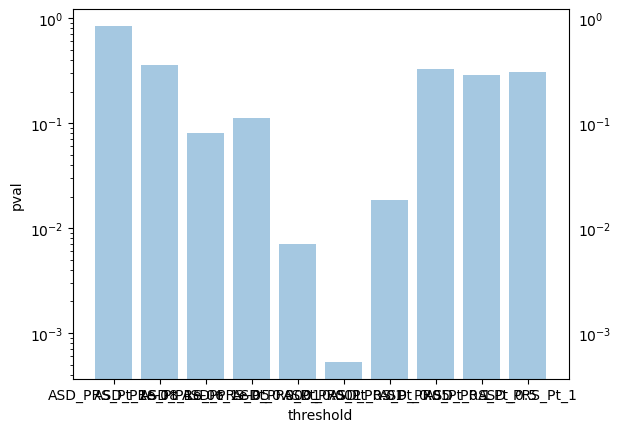

In [36]:
ax = plt.subplot(111)
visualisation.SimplePlots.Bar(
    x='threshold',
    y='pval',
    order = {'x':thresholds},
    yscalelog=True,
    ax=ax,
    data=high_low_values[high_low_values['phenotype']=='Frontal+Temporal TTV'],alpha=0.4)
plt.tick_params(axis='y', labelleft='off', labelright='on')

In [69]:
high_low_values.sort_values(by='pval')

,tval,pval,threshold,phenotype
0,3.535423,0.000531,ASD_PRS_Pt_0.01,Frontal+Temporal TTV
0,-3.470953,0.000665,ASD_PRS_Pt_0.01,Parietal+Occipital TTV
0,-2.821709,0.005375,ASD_PRS_Pt_0.0001,Parietal+Occipital TTV
0,-2.745241,0.006730,ASD_PRS_Pt_0.001,Parietal+Occipital TTV
0,2.728356,0.007068,ASD_PRS_Pt_0.001,Frontal+Temporal TTV
0,2.379770,0.018486,ASD_PRS_Pt_0.05,Frontal+Temporal TTV
0,-2.107563,0.036608,ASD_PRS_Pt_0.05,Parietal+Occipital TTV
0,1.757906,0.080652,ASD_PRS_Pt_1e-05,Frontal+Temporal TTV
0,1.602628,0.110965,ASD_PRS_Pt_0.0001,Frontal+Temporal TTV
0,-1.220931,0.223886,ASD_PRS_Pt_1,Parietal+Occipital TTV


In [134]:
european_mass_univariate.sort_values(by="standardize(Q('PRS_pca'))_pval")

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
Frontal+Temporal TTV,164263.857136,0.000000e+00,181.309758,0.666786,-543.336638,0.004344,-2137.570069,6.267407e-09,96.229701,0.688441,22937.306227,2.198864e-178,7.796176,0.967285,-413.730176,0.028530,232.516290,0.219976
Parietal+Occipital TTV,119001.448924,0.000000e+00,457.529006,0.317639,562.227081,0.006561,77.939089,8.404038e-01,319.585511,0.220884,16179.946715,2.256021e-132,-73.644129,0.721417,234.472830,0.251728,-110.270600,0.591917
Frontal lobe TTV,113818.306310,0.000000e+00,49.682108,0.906677,-501.390078,0.008849,-2039.101370,3.332878e-08,174.902728,0.469201,16306.311078,4.237770e-141,119.826600,0.531295,-304.396820,0.108698,269.145472,0.158568
Parietal lobe TTV,73540.556653,0.000000e+00,158.512707,0.664903,370.269005,0.024892,121.477872,6.948077e-01,219.484076,0.293062,9561.430377,2.375222e-102,-79.271957,0.631389,219.719547,0.179571,-161.713898,0.326025
Parietal+Temporal TTV,123986.107479,0.000000e+00,290.140357,0.509196,328.322445,0.096931,23.009173,9.506474e-01,140.811048,0.574008,16192.425526,1.305583e-136,-191.302380,0.335278,110.386191,0.573922,-198.343079,0.315805
Frontal+Occipital TTV,159279.198581,0.000000e+00,348.698408,0.419422,-309.432001,0.111183,-2082.640153,3.059536e-08,275.004163,0.264136,22924.827416,1.292819e-175,125.454427,0.519858,-289.643536,0.133826,320.588770,0.099379
Occipital lobe TTV,45460.892271,7.395396e-304,299.016299,0.318808,191.958076,0.154467,-43.538783,8.636618e-01,100.101435,0.557921,6618.516338,6.688112e-87,5.627828,0.966820,14.753284,0.912237,51.443298,0.702625
Occipital+Temporal TTV,95906.443098,0.000000e+00,430.643949,0.226575,150.011516,0.347913,-142.007483,6.370486e-01,21.428407,0.915805,13249.511488,9.787467e-138,-106.402595,0.507716,-94.580072,0.551728,14.814116,0.926183
Frontal+Parietal TTV,187358.862962,0.000000e+00,208.194816,0.623236,-131.121073,0.490869,-1917.623497,1.868661e-07,394.386804,0.103286,25867.741455,6.617181e-191,40.554643,0.832110,-84.677273,0.654635,107.431574,0.572891
Temporal lobe TTV,50445.550827,0.000000e+00,131.627649,0.606153,-41.946560,0.714390,-98.468700,6.484859e-01,-78.673028,0.588732,6630.995149,8.533986e-102,-112.030423,0.331397,-109.333356,0.337999,-36.629182,0.749604


In [195]:
stats.matSpDLite(np.corrcoef(new_df[[i for i in new_df.columns if 'TTV' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 1.947786082369558
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 2.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.025670170072872193


2.0000000000000004

In [141]:
groupings = ['gmwm2gether','lobe']

In [142]:
new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=groupings)

In [154]:
new_df['Frontal lobe TTV R'] = new_df['Imperial 36']
new_df['Frontal lobe TTV L'] = new_df['Imperial 37']

new_df['Parietal lobe TTV R'] = new_df['Imperial 38']
new_df['Parietal lobe TTV L'] = new_df['Imperial 39']

new_df['Occipital lobe TTV R'] = new_df['Imperial 22']
new_df['Occipital lobe TTV L'] = new_df['Imperial 23']

new_df['Temporal lobe TTV R'] = new_df['Imperial 6']
new_df['Temporal lobe TTV L'] = new_df['Imperial 5']

new_df['Frontal+Parietal TTV R'] = new_df['Frontal lobe TTV R'] + new_df['Parietal lobe TTV R']
new_df['Frontal+Occipital TTV R'] = new_df['Frontal lobe TTV R'] + new_df['Occipital lobe TTV R']
new_df['Frontal+Temporal TTV R'] = new_df['Frontal lobe TTV R'] + new_df['Temporal lobe TTV R']
new_df['Parietal+Occipital TTV R'] = new_df['Parietal lobe TTV R'] + new_df['Occipital lobe TTV R']
new_df['Parietal+Temporal TTV R'] = new_df['Parietal lobe TTV R'] + new_df['Temporal lobe TTV R']
new_df['Occipital+Temporal TTV R'] = new_df['Temporal lobe TTV R'] + new_df['Occipital lobe TTV R']

new_df['Frontal+Parietal TTV L'] = new_df['Frontal lobe TTV L'] + new_df['Parietal lobe TTV L']
new_df['Frontal+Occipital TTV L'] = new_df['Frontal lobe TTV L'] + new_df['Occipital lobe TTV L']
new_df['Frontal+Temporal TTV L'] = new_df['Frontal lobe TTV L'] + new_df['Temporal lobe TTV L']
new_df['Parietal+Occipital TTV L'] = new_df['Parietal lobe TTV L'] + new_df['Occipital lobe TTV L']
new_df['Parietal+Temporal TTV L'] = new_df['Parietal lobe TTV L'] + new_df['Temporal lobe TTV L']
new_df['Occipital+Temporal TTV L'] = new_df['Temporal lobe TTV L'] + new_df['Occipital lobe TTV L']




In [155]:
_, european_mass_univariate = stats.MassUnivariate.mass_univariate(new_df,
                                     cat_independentVar_cols=['sex'],
                                     cont_independentVar_cols=['PRS_pca','PMA','GA','TBV']+ancestry,
                                     dependentVar_cols=[i for i in new_df.columns if 'TTV' in i])

In [158]:
survived, fdrpval = fdrcorrection(european_mass_univariate["standardize(Q('PRS_pca'))_pval"].values,method='p',alpha=0.05)

In [156]:
european_mass_univariate.sort_values(by="standardize(Q('PRS_pca'))_pval")

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
Parietal+Occipital TTV L,59759.904003,0.000000e+00,266.080023,0.268766,299.417587,0.005871,47.294670,8.160868e-01,186.595161,0.173842,8086.144134,2.972581e-127,-51.996972,0.631848,112.279926,0.296086,-70.872347,0.512037
Frontal+Temporal TTV L,81740.533524,0.000000e+00,28.702447,0.900701,-283.987494,0.006330,-960.492795,1.390389e-06,-52.692360,0.687784,11363.673972,9.877270e-168,6.117098,0.953031,-241.957933,0.019152,150.786294,0.145651
Frontal lobe TTV L,57008.983283,0.000000e+00,-110.814749,0.607268,-246.637709,0.011313,-935.706407,5.471623e-07,7.261790,0.952863,8137.490673,4.093490e-139,24.184231,0.803752,-162.805405,0.091729,135.425662,0.163061
Frontal lobe TTV R,56809.323027,0.000000e+00,160.496858,0.484880,-254.752369,0.014042,-1103.394962,3.488921e-08,167.640939,0.201002,8168.820405,6.188639e-133,95.642368,0.356738,-141.591415,0.168314,133.719810,0.196044
Frontal+Temporal TTV R,82523.323612,0.000000e+00,152.607311,0.526806,-259.349144,0.017151,-1177.077274,2.134241e-08,148.922060,0.278872,11573.632256,1.175092e-164,1.679078,0.987690,-171.772243,0.111484,81.729996,0.450988
Parietal lobe TTV R,36682.516820,0.000000e+00,1.481470,0.993996,207.694793,0.019416,88.788442,5.941111e-01,85.434422,0.446646,4760.307667,4.316994e-95,0.836544,0.992491,103.765902,0.238627,-104.179919,0.239806
Parietal+Occipital TTV R,59241.544921,0.000000e+00,191.448984,0.445910,262.809494,0.020351,30.644419,8.852810e-01,132.990349,0.352988,8093.802581,6.198256e-123,-21.647157,0.848528,122.192904,0.276364,-39.398253,0.727054
Parietal lobe TTV L,36858.039833,0.000000e+00,157.031238,0.411632,162.574212,0.059040,32.689430,8.398222e-01,134.049654,0.219160,4801.122709,1.264458e-98,-80.108501,0.353652,115.953645,0.175187,-57.533979,0.503362
Parietal+Temporal TTV R,62396.517405,0.000000e+00,-6.408077,0.978935,203.098019,0.063210,15.106130,9.413563e-01,66.715543,0.629640,8165.119518,3.039909e-127,-93.126746,0.395692,73.585073,0.497459,-156.169733,0.153150
Occipital lobe TTV L,22901.864170,1.354288e-291,109.048785,0.516703,136.843376,0.070707,14.605240,9.182149e-01,52.545507,0.583494,3285.021425,2.343126e-76,28.111529,0.711128,-3.673719,0.960980,-13.338368,0.859921


In [157]:
stats.matSpDLite(np.corrcoef(new_df[[i for i in new_df.columns if 'TTV' in i]],rowvar=False))

Effective Number of Independent Variables [Veff] is 2.8889789387726665
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 2.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.02499999999999988


2.0000000000000098

In [34]:
FA_names = ['ID/Ses']+['FA_Uus_'+str(i) for i in range(94,148)]
FD_names = ['ID/Ses']+['FD_Uus_'+str(i) for i in range(94,148)]
MD_names = ['ID/Ses']+['MD_Uus_'+str(i) for i in range(94,148)]

In [35]:
mean_fa_fsl = pd.read_csv('../../codes/FBA/output/aba/mean_fa.txt',delim_whitespace=True,header=None,names=FA_names)
mean_fd = pd.read_csv('../../codes/FBA/output/aba/mean_fd.txt',delim_whitespace=True,header=None,names=FD_names)
mean_md = pd.read_csv('../../codes/FBA/output/aba/mean_md.txt',delim_whitespace=True,header=None,names=MD_names)


In [36]:
for temp_df in [mean_fa_fsl,mean_md,mean_fd]:
    temp_df['ID'] = temp_df['ID/Ses'].str.split('_').apply(lambda x: x[0].replace('sub-',''))
    temp_df['Session'] = temp_df['ID/Ses'].str.split('_').apply(lambda x: int(x[1].replace('ses-','')))

In [37]:
tract_df = df.merge(mean_fa_fsl,on=['ID','Session'])
tract_df = tract_df.merge(mean_md,on=['ID','Session'])
tract_df = tract_df.merge(mean_fd,on=['ID','Session'])

In [44]:
_, european_mass_univariate = stats.MassUnivariate.mass_univariate(tract_df,
                                     cat_independentVar_cols=['sex'],
                                     cont_independentVar_cols=['PRS_pca','PMA','GA']+ancestry,
                                     dependentVar_cols=[i for i in tract_df.columns if 'FD_Uus' in i])

In [45]:
european_mass_univariate.sort_values(by="standardize(Q('PRS_pca'))_pval")

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
FD_Uus_133,0.249868,3.397466e-270,-0.002365,7.393773e-02,-0.001556,0.020224,-0.001798,3.589818e-02,0.003067,0.000356,0.001014,0.133798,-0.000116,0.862004,0.000442,0.513165
FD_Uus_105,0.165708,1.618747e-182,-0.009887,2.475790e-05,-0.002356,0.043156,0.010139,8.362057e-11,0.002684,0.069484,-0.000487,0.678175,-0.001529,0.189977,-0.000851,0.469641
FD_Uus_132,0.254587,1.266017e-279,-0.002280,6.098421e-02,-0.001038,0.090880,-0.000804,3.052490e-01,0.002549,0.001206,0.001087,0.080530,-0.000047,0.938581,0.000695,0.263719
FD_Uus_104,0.167444,1.182080e-182,-0.010676,6.802261e-06,-0.001911,0.103506,0.009323,2.428622e-09,0.002906,0.051543,-0.000093,0.937755,-0.000646,0.582705,-0.001099,0.354993
FD_Uus_113,0.212658,1.611672e-250,-0.002748,4.934438e-02,-0.001092,0.121448,0.004724,3.582155e-07,0.000097,0.913099,-0.000498,0.484488,-0.000724,0.305510,-0.000643,0.367537
FD_Uus_141,0.262929,1.054678e-297,-0.001140,2.676474e-01,-0.000760,0.144123,0.001776,7.962543e-03,0.001400,0.034590,0.000198,0.706132,0.000367,0.481954,0.000136,0.795780
FD_Uus_112,0.215760,2.102847e-257,-0.002162,9.988332e-02,-0.000967,0.144659,0.004068,2.855438e-06,-0.000218,0.795452,0.000397,0.553806,0.000188,0.777439,-0.000635,0.344423
FD_Uus_98,0.243384,5.295971e-260,-0.004784,1.005235e-03,-0.000919,0.206078,0.004757,6.522053e-07,0.002480,0.007613,0.000588,0.423934,-0.000141,0.846486,-0.000006,0.993084
FD_Uus_107,0.204080,1.218277e-236,-0.004665,2.999438e-03,-0.000930,0.237267,0.003491,6.181915e-04,0.002827,0.005023,0.000558,0.483548,-0.001347,0.088854,-0.000620,0.436918
FD_Uus_99,0.246868,3.589732e-268,-0.004374,1.179736e-03,-0.000793,0.238973,0.006923,5.930510e-14,0.001771,0.039241,0.000256,0.707223,-0.000497,0.462622,-0.000067,0.921431


In [51]:
data_preprocessing.Volumes.Imperial.get_Imperial_legends(grouping=groupings,
                                                         df=data_preprocessing.Volumes.Imperial.get_segment(
                                                             european_mass_univariate,
                                                             tissue=['WM','GM'],col='index')).sort_values(by="standardize(Q('PRS_pca'))_pval")

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
parietal.right,36699.673088,0.000000e+00,-31.973253,0.869509,-213.135622,0.015655,96.858258,5.612718e-01,86.296555,0.441486,4762.283307,3.062232e-95,-2.434993,0.978154,114.632568,0.194637,-97.537665,0.270872
frontal.left,56984.121986,0.000000e+00,-62.335220,0.770681,215.137806,0.026268,-939.405408,5.492820e-07,1.906638,0.987645,8131.449863,8.525903e-139,24.286137,0.803701,-171.520179,0.077762,128.618399,0.186581
frontal.right,56784.230803,0.000000e+00,209.426694,0.358135,227.181196,0.027544,-1107.985253,3.425315e-08,162.676120,0.215382,8163.064099,1.106551e-132,96.242432,0.355353,-151.140868,0.144059,126.547266,0.222254
parietal.left,36870.997620,0.000000e+00,131.763553,0.485758,-170.819879,0.045632,39.624077,8.065523e-01,134.269593,0.217765,4802.281113,9.064636e-99,-83.066627,0.336345,124.899576,0.145657,-52.221249,0.543376
occipital.left,22918.761392,5.190419e-292,76.099204,0.648392,-93.118803,0.216195,12.589263,9.297942e-01,58.511575,0.542627,3290.927734,2.846528e-76,30.670700,0.687493,-1.735130,0.981702,-10.308489,0.891911
occipital.right,22559.622880,6.486527e-282,188.807696,0.293285,-90.033813,0.266139,-50.813936,7.409586e-01,43.965147,0.670544,3330.761022,2.780196e-71,-26.687878,0.744850,25.004991,0.758645,67.497032,0.408415
temporal.left,24730.989926,1.940704e-317,140.609811,0.329508,59.683551,0.358303,-29.547646,8.107388e-01,-57.672526,0.487093,3227.906536,2.935911e-87,-15.350616,0.815613,-83.463477,0.202051,13.558353,0.836021
temporal.right,25717.956566,0.000000e+00,-15.603709,0.911140,41.388015,0.511407,-79.544867,5.066563e-01,-14.553790,0.856539,3408.337300,6.836278e-95,-90.236400,0.158571,-34.468361,0.586745,-53.180523,0.403129


In [23]:
grouped_volumes_dict = data_preprocessing.Volumes.Imperial.get_Imperial_legends(['lobe'])

In [25]:
grouped_volumes_dict = {k:v['abbr'] for k,v in grouped_volumes_dict.items() if k in df.columns}

In [27]:
unique_grouped_volumes_dict = defaultdict(list)
for k,v in grouped_volumes_dict.items():
    unique_grouped_volumes_dict[v].append(k)

In [19]:
data_preprocessing.Volumes.Imperial.get_Imperial_legends()['Imperial 1']

{'name': 'Hippocampus left',
 'tissue': None,
 'lobe': None,
 'side': 'left',
 'segment': None,
 'structure': 'Hippocampus',
 'abbr': 'HIPP.left'}

In [ ]:
new

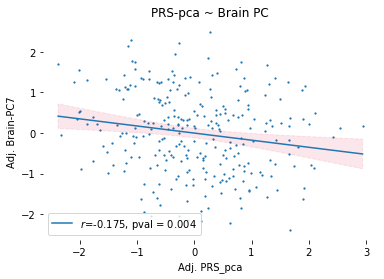

In [12]:
visualisation.SimplePlots.Scatter(prs_pca,
                                  brain_pca[:, 6],
                                  legend_loc='lower left',
                                  xlabel='PRS_pca',
                                  ylabel='Brain-PC7',
                                  data=df,
                                  adjust_covar={
                                      'x': ['sex'] + ancestry,
                                      'y': ['GA', 'PMA','TBV']
                                  },
                                  title='PRS-pca ~ Brain PC')
sns.despine(bottom=True, left=True)

PRS-PC1 is associated with one of the brain volume PC. Graph analysis is used to check if there is any association between correlation matrices between PRS-PC1 and combination of the brain volumes.

There appears to be some positional pattern in the correlation values between the PRS-PC1 and total tissue brain volumes (WM + GM).

In [15]:
grouped_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['gmwm2gether'], drop_duplicates=False).copy()# grouped the WM and GM together.
adjusted_df = stats.MassUnivariate.adjust_covariates_with_lin_reg(grouped_df,
                                                                 cat_independentVar_cols=['sex'],
                                                                 cont_independentVar_cols=['GA','PMA','TBV'],
                                                                dependentVar_cols=data_preprocessing.Volumes.Imperial.get_segment(grouped_df,col='column',tissue=['WM','GM','Cerebellum']))
prs_loading_matrix = adjusted_df.apply(lambda x: np.corrcoef(x.values, prs_pca[:,0])[0, 1], axis=0)

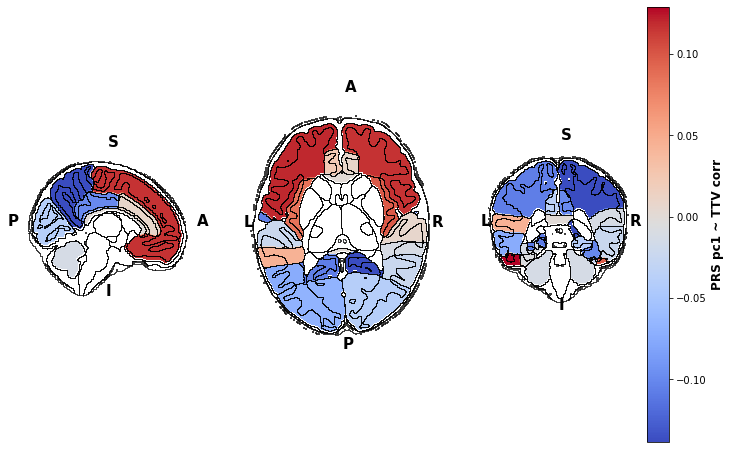

In [16]:
plot_labels = [int(i.replace('Imperial ','')) for i in prs_loading_matrix.index]

prs_plot_value_values = prs_loading_matrix.values
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 

fig,ax = plt.subplots(1,3,figsize=(12,8))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
#     atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap='coolwarm',
    cmap_reversed=False,
    axes=ax,
    fig=fig,
    cb_title='PRS pc1 ~ TTV corr')


In fact, grouping the regions into their respective lobes (Frontal, temporal, occipital and parietal (not including insula and cingulate)) also show the same effect

In [117]:
grouped_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['gmwm2gether','lobe'], drop_duplicates=False).copy()# grouped the WM and GM together.
adjusted_df = stats.MassUnivariate.adjust_covariates_with_lin_reg(grouped_df,
                                                                 cat_independentVar_cols=['sex'],
                                                                 cont_independentVar_cols=['GA','PMA','TBV'],
                                                                dependentVar_cols=data_preprocessing.Volumes.Imperial.get_segment(grouped_df,col='column',lobe=['occipital','temporal','frontal','parietal']))
prs_loading_matrix = adjusted_df.apply(lambda x: np.corrcoef(x.values, prs_pca[:,0])[0, 1], axis=0)

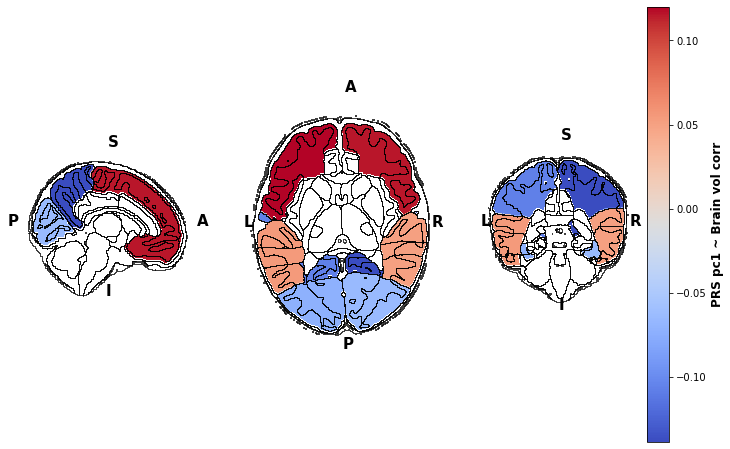

In [119]:
plot_labels = [int(i.replace('Imperial ','')) for i in prs_loading_matrix.index]

prs_plot_value_values = prs_loading_matrix.values
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 

fig,ax = plt.subplots(1,3,figsize=(12,8))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
#     atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap='coolwarm',
    cmap_reversed=False,
    axes=ax,
    fig=fig,
    cb_title='PRS pc1 ~ Brain vol corr')

plt.savefig('OHBM_lobule_vol.png',dpi=250)

In [89]:
grouped_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['gmwm2gether','lobe','hemisphere']).copy()# grouped the WM and GM together.
adjusted_df = stats.MassUnivariate.adjust_covariates_with_lin_reg(grouped_df,
                                                                 cat_independentVar_cols=['sex'],
                                                                 cont_independentVar_cols=['GA','PMA','TBV'],
                                                                dependentVar_cols=data_preprocessing.Volumes.Imperial.get_segment(grouped_df,col='column',lobe=['occipital','temporal','frontal','parietal']))

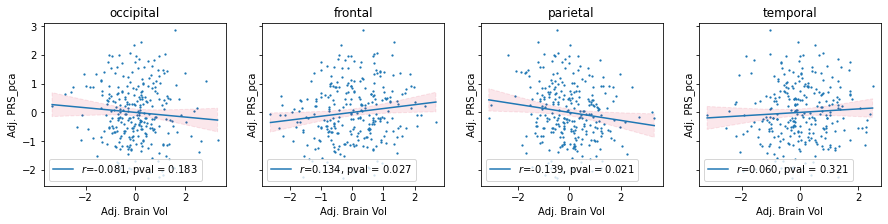

In [95]:
fig,axes = plt.subplots(1,4,figsize=(15,3),sharey=True)
for (idx,ax),name in zip(enumerate(axes.flatten()),['occipital','frontal','parietal','temporal']):
    visualisation.SimplePlots.Scatter(x=adjusted_df.values[:,idx],
                                     y = prs_pca,adjust_covar={'y':ancestry},data = grouped_df,ax=ax,legend_loc='lower left',title=name,ylabel='PRS_pca', xlabel='Adj. Brain Vol')

And here is the plot between the summed Frontal and Parietal TTV

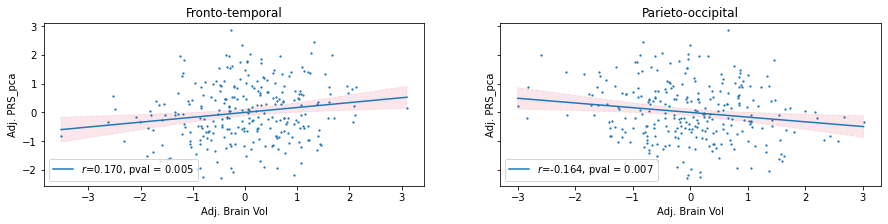

In [30]:
adjusted_df['Fronto-temporal']  = adjusted_df['Imperial 36'] + adjusted_df['Imperial 5']
adjusted_df['Parieto-occipital']  = adjusted_df['Imperial 22'] + adjusted_df['Imperial 38']

fig,axes = plt.subplots(1,2,figsize=(15,3),sharey=True)
for (idx,ax),name in zip(enumerate(axes.flatten()),['Fronto-temporal','Parieto-occipital']):
    visualisation.SimplePlots.Scatter(x=adjusted_df[name],
                                     y = prs_pca,adjust_covar={'y':ancestry},data = grouped_df,ax=ax,legend_loc='lower left',title=name,ylabel='PRS_pca', xlabel='Adj. Brain Vol')

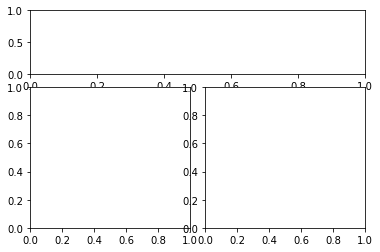

In [109]:
fig = plt.figure()

gs = fig.add_gridspec(3,4)
axes = fig.add_subplot(gs[0, :])
plot1 = fig.add_subplot(gs[1:,0:2])
plot2 = fig.add_subplot(gs[1:,2:])

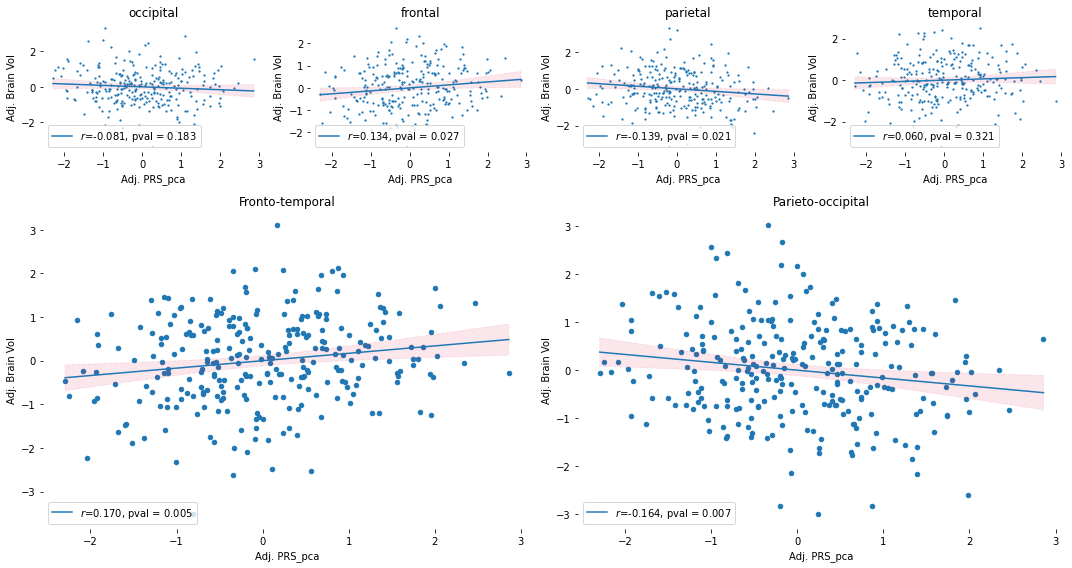

In [116]:

fig = plt.figure(figsize=(15,8))

gs = fig.add_gridspec(3,4)
axes1 = fig.add_subplot(gs[0, 0])
axes2 = fig.add_subplot(gs[0, 1])
axes3 = fig.add_subplot(gs[0, 2])
axes4 = fig.add_subplot(gs[0, 3])
plot1 = fig.add_subplot(gs[1:,0:2])
plot2 = fig.add_subplot(gs[1:,2:])

for (idx,ax),name in zip(enumerate([axes1,axes2,axes3,axes4]),['occipital','frontal','parietal','temporal']):
    visualisation.SimplePlots.Scatter(y=adjusted_df.values[:,idx],
                                     x = prs_pca,adjust_covar={'x':ancestry},data = grouped_df,ax=ax,legend_loc='lower left',title=name,xlabel='PRS_pca', ylabel='Adj. Brain Vol')
    
adjusted_df['Fronto-temporal']  = adjusted_df['Imperial 36'] + adjusted_df['Imperial 5']
adjusted_df['Parieto-occipital']  = adjusted_df['Imperial 22'] + adjusted_df['Imperial 38']

for (idx,ax),name in zip(enumerate([plot1,plot2]),['Fronto-temporal','Parieto-occipital']):
    visualisation.SimplePlots.Scatter(y=adjusted_df[name],
                                     x = prs_pca,adjust_covar={'x':ancestry},data = grouped_df,ax=ax,legend_loc='lower left',title=name,xlabel='PRS_pca', ylabel='Adj. Brain Vol',markersize=20)
    
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('OHBM_image.png',dpi=200)

Here is a plot showing the correlation between A-P position between brain regions and the PRS-PC1

In [11]:
ROIs_coord_Imperial = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/Imperial/atlas_t40.nii.gz')
ROIs_coord_Imperial['Label'] = [f'Imperial {int(i)}' for i in ROIs_coord_Imperial['Label']]

In [12]:
new_ROIs_coord_Imperial = ROIs_coord_Imperial.set_index('Label').T.copy()
new_ROIs_coord_Imperial = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(new_ROIs_coord_Imperial,grouping=['gmwm2gether'],operation='mean',drop_duplicates=False).T
new_ROIs_coord_Imperial = new_ROIs_coord_Imperial.drop([i for i in new_ROIs_coord_Imperial.index if not bool(re.search('Imperial \d',i))])

In [13]:
standardized_ROIs_coord = new_ROIs_coord_Imperial.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(new_ROIs_coord_Imperial[['X','Y','Z']])

In [14]:
Imperial_labels = data_preprocessing.Volumes.Imperial.get_Imperial_legends(grouping='gmwm2gether')

<AxesSubplot:title={'center':'corr(PRS~brainVol) / A-P axis'}, xlabel='A-P axis', ylabel='PRS~BrainVol corr'>

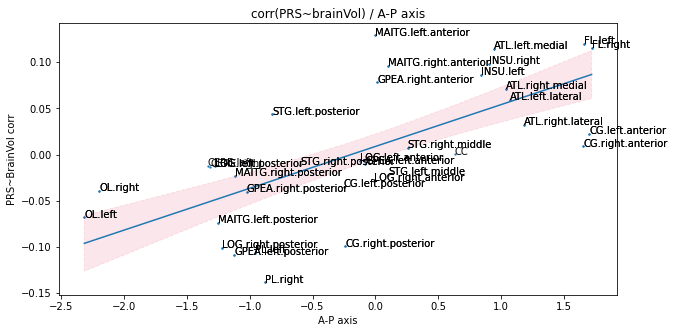

In [40]:
fig,axes = plt.subplots(1,1,figsize=(10,5))
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[prs_loading_matrix.index,'Y'],
                                  y=prs_loading_matrix, annotate=[Imperial_labels[i]['abbr'] for i in prs_loading_matrix.index],ylabel='PRS~BrainVol corr', xlabel='A-P axis',scaling=None,return_stats=True, legend=False,title='corr(PRS~brainVol) / A-P axis',ax=axes)

In fact, summing the regions in the anterior and posterior regions shows a very similar pattern to summing up the lobule volumes as shown above

In [24]:
posterior_labels = standardized_ROIs_coord[standardized_ROIs_coord['Y']<=0].index.to_list()
anterior_labels = standardized_ROIs_coord[standardized_ROIs_coord['Y']>0].index.to_list()

posterior_labels = data_preprocessing.Volumes.Imperial.get_segment(posterior_labels,tissue=['WM','GM'])
anterior_labels = data_preprocessing.Volumes.Imperial.get_segment(anterior_labels,tissue=['WM','GM'])
df['Anterior_volumes'] = df[[i for i in df.columns if i in anterior_labels]].sum(axis=1)
df['Posterior_volumes'] = df[[i for i in df.columns if i in posterior_labels]].sum(axis=1)

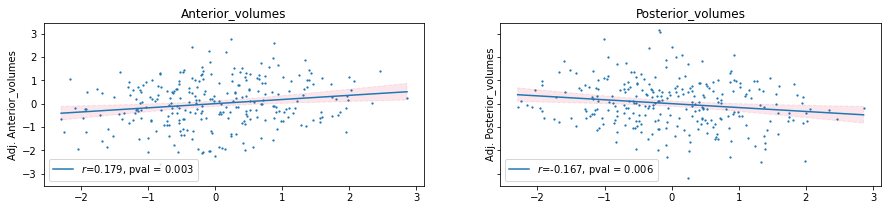

In [25]:
fig,axes = plt.subplots(1,2,figsize=(15,3),sharey=True)
for (idx,ax),name in zip(enumerate(axes.flatten()),['Anterior_volumes','Posterior_volumes']):
    visualisation.SimplePlots.Scatter(x=prs_pca,
                                     y = name,adjust_covar={'x':ancestry,
                                                              'y':['sex','PMA','GA','TBV']},data = df,ax=ax,legend_loc='lower left',title=name,scaling='both')

In [ ]:
stats.MassUnivariate.mass_univariate()

### Regression model

In [209]:
to_permute = df['euro_ld_no_dups_genPt_1'].values
to_permute = prs_pca

In [178]:
result_dict_Imperial = defaultdict(dict)
for prs in prs_labels:
    result_dict_Imperial[prs]['observed_matrix'] = graph_analysis.NBS.Corr_matrix.calculate_adj_corr_matrix(X,y,to_permute=df[prs].values)
    result_dict_Imperial[prs]['permutation_matrices'] = graph_analysis.NBS.Corr_matrix.get_permutation_corr_matrix(X,y,to_permute=df[prs].values,perm=1000)

100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 132.74it/s]


In [179]:
for prs in prs_labels:
    result_dict_Imperial[prs]['null_distribution']=dict()
    result_dict_Imperial[prs]['observed_metrics'] = dict()
    for threshold in tqdm.tqdm([0.2,0.3,0.4]):
        result_dict_Imperial[prs]['null_distribution'][threshold] = graph_analysis.NBS.get_null_distribution(result_dict_Imperial[prs]['permutation_matrices'],
                                                             threshold=threshold,
                                                            metrics = ['max_edge_size',
                                                                      'max_degree_centrality'])
        result_dict_Imperial[prs]['observed_metrics'][threshold] = graph_analysis.NBS.get_p_val(result_dict_Imperial[prs]['observed_matrix'] ,threshold=threshold,null_distribution=result_dict_Imperial[prs]['null_distribution'][threshold])

100%|█████████████████████████████████████████████| 3/3 [00:27<00:00,  9.15s/it]


In [180]:
result_dict_Imperial.keys()

dict_keys(['euro_ld_no_dups_genPt_1e-08', 'euro_ld_no_dups_genPt_1e-07', 'euro_ld_no_dups_genPt_1e-06', 'euro_ld_no_dups_genPt_1e-05', 'euro_ld_no_dups_genPt_0.0001', 'euro_ld_no_dups_genPt_0.001', 'euro_ld_no_dups_genPt_0.01', 'euro_ld_no_dups_genPt_0.05', 'euro_ld_no_dups_genPt_0.1', 'euro_ld_no_dups_genPt_0.5', 'euro_ld_no_dups_genPt_1', 'PRS_pca_euro_ld_no_dups_gen'])

In [183]:
result_dict_Imperial['PRS_pca_euro_ld_no_dups_gen']['observed_metrics']

{0.2: defaultdict(dict,
             {'max_edge_size': {'p_vals': array([0.628]),
               'comps': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                      1, 1, 1, 1, 1]),
               'ind_sz': array([1]),
               'sz_links': array([360.])},
              'max_degree_centrality': {'p_vals': array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                      1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                      1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                      1.   , 1.   , 0.762, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                      1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,

In [181]:
[v['observed_metrics'] for k,v in result_dict_Imperial.items()]

[{0.2: defaultdict(dict,
              {'max_edge_size': {'p_vals': array([0.811]),
                'comps': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1]),
                'ind_sz': array([1]),
                'sz_links': array([358.])},
               'max_degree_centrality': {'p_vals': array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                       1.   , 0.999, 0.749, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                       1.   , 1.   , 1.   , 1.   ,

In [216]:
observed_matrix = graph_analysis.NBS.Corr_matrix.calculate_adj_corr_matrix(X,y,to_permute=to_permute)

In [217]:
permutation_matrices = graph_analysis.NBS.Corr_matrix.get_permutation_corr_matrix(X,y,to_permute=to_permute,perm=1000)

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 154.17it/s]


In [218]:
threshold = 0.3
null_distribution = graph_analysis.NBS.get_null_distribution(permutation_matrices,
                                                             threshold=threshold,
                                                            metrics = ['max_edge_size',
                                                                      'max_degree_centrality'])

In [219]:
observed_metrics = graph_analysis.NBS.get_p_val(observed_matrix,threshold=threshold,null_distribution=null_distribution)

In [165]:
observed_square = graph_analysis.Graph_analysis.reverse_lower_triangle(observed_matrix)

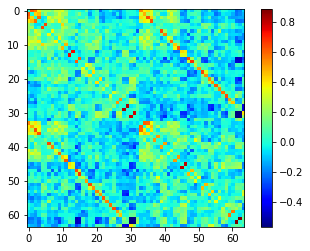

In [166]:
plt.imshow(observed_square,cmap='jet')
plt.colorbar()

In [220]:
observed_metrics

defaultdict(dict,
            {'max_edge_size': {'p_vals': array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.923,
                     1.   , 1.   , 1.   , 1.   ]),
              'comps': array([ 1,  1,  3,  3,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2, 12, 12, 11,
                     11,  3,  3, 12, 12,  3,  3,  4,  4,  4,  4, 10, 10, 12, 12, 12, 12,
                      5,  5, 10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8,  8,  8,  8,
                      8,  8,  6,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
                      9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 13,
                     13, 12, 12, 13, 13, 14, 14, 14]),
              'ind_sz': array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14]),
              'sz_links': array([ 1.,  4.,  6., 21.,  1.,  1., 38.,  1., 48.,  5., 16.,  3.,  3.])},
             'max_degree_centrality': {'p_vals': array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
      

### Low/ high risk model

In [22]:
high_risk,low_risk = data_exploration.Stability_tests.divide_high_low_risk(prs_pca.reshape(-1),high_perc=0.1,low_perc=0.1)

## Feature selection analysis

In [296]:
AAL_cols = [i for i in df.columns if re.search('AAL \d',i)]
Imperial_cols = [i for i in df.columns if re.search('Imperial \d',i) and i in cor_labels]
prs_labels = [i for i in df.columns if 'euro_ld_no_dups_gen' in i]
prs_label = 'euro_ld_no_dups_genPt_1'



_, prs_pca, prs_loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(df,
                                                              dependentVar_cols=prs_labels,n_components=.80)


In [240]:
from sklearn.linear_model import RidgeCV,Ridge,Lasso,LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector, RFE,RFECV

In [235]:
adjusted_df = df.copy()
adjusted_df[
    Imperial_cols] = data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
        df,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=[
            'Total_Brain_Volume_Imperial', 'Intracranial_Imperial', 'PMA_vol',
            'GA_vol'
        ],
        dependentVar_cols=Imperial_cols)

adjusted_df[prs_label] =data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
        df,
        cont_independentVar_cols=ancestry,
        dependentVar_cols=[prs_label])

In [238]:
train,test = train_test_split(df,test_size=.2)

In [250]:
const_train=np.ones((len(train),1))
const_test = np.ones((len(test),1))
X_train = np.empty((len(train),len(Imperial_cols)))
X_test = np.empty((len(test),len(Imperial_cols)))
for idx,col in enumerate(Imperial_cols):
    adjust_volumes = LinearRegression()
    temp_X_train = np.concatenate([const_train,train[['Gender','Total_Brain_Volume_Imperial', 'Intracranial_Imperial', 'PMA_vol','GA_vol']].values],axis=1)
    temp_X_test = np.concatenate([const_test,test[['Gender','Total_Brain_Volume_Imperial', 'Intracranial_Imperial', 'PMA_vol','GA_vol']].values],axis=1)
    adjust_volumes.fit(temp_X_train,train[col].values)
    X_train[:,idx] = train[col].values - adjust_volumes.predict(temp_X_train)
    X_test[:,idx] = test[col].values - adjust_volumes.predict(temp_X_test)

y_train = np.empty((len(train),len(prs_labels)))
y_test = np.empty((len(test),len(prs_labels)))
for idx,col in enumerate(prs_labels):
    adjust_volumes = LinearRegression()
    temp_X_train = np.concatenate([const_train,train[ancestry].values],axis=1)
    temp_X_test = np.concatenate([const_test,test[ancestry].values],axis=1)
    adjust_volumes.fit(temp_X_train,train[col].values)
    y_train[:,idx] = train[col].values - adjust_volumes.predict(temp_X_train)
    y_test[:,idx] = test[col].values - adjust_volumes.predict(temp_X_test)


In [254]:
y_train = y_train[:,np.array(prs_labels)==prs_label].reshape(-1)
y_test = y_test[:,np.array(prs_labels)==prs_label].reshape(-1)

In [266]:
model = Ridge()
selector = RFECV(model,step=1,scoring='neg_mean_squared_error')

In [267]:
selector.fit(X_train,y_train)

RFECV(estimator=Ridge(), scoring='neg_mean_squared_error')

In [282]:
np.array(Imperial_cols)[selector.support_]

array(['Imperial 13'], dtype='<U11')

In [269]:
selector.ranking_

array([ 7,  3,  8, 36, 31, 30, 41, 44,  1, 40, 12, 51, 56, 38, 42, 43, 13,
       37, 21, 32, 35, 58, 16,  9, 27, 15, 18, 55, 46, 47, 53, 52, 29,  6,
        2,  5, 28, 19, 26, 50, 61, 63, 64, 24, 14,  4, 39, 62, 60, 25, 20,
       22, 33, 45, 23, 17, 34, 11, 10, 65, 54, 57, 59, 49, 48])

In [291]:
np.sqrt(-selector.cv_results_['mean_test_score'].mean())

3.8533414611487746e-05

In [293]:
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
np.sqrt(mean_squared_error(y_test,selector.predict(X_test)))
r2_score(y_test,selector.predict(X_test))

explained_variance_score(y_test,selector.predict(X_test))

-0.03225340366953122

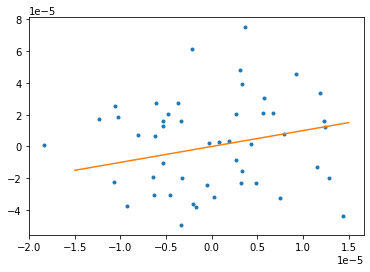

In [287]:
plt.plot(selector.predict(X_test),y_test,'.')
plt.plot([-1.5e-5,1.5e-5],[-1.5e-5,1.5e-5])

In [280]:
selector.estimator_

Ridge()

1

In [73]:
np.array(Imperial_cols)[np.argsort(selector.ranking_)[:10]]

array(['Imperial 6', 'Imperial 76', 'Imperial 33', 'Imperial 52',
       'Imperial 75', 'Imperial 63', 'Imperial 32', 'Imperial 57',
       'Imperial 13', 'Imperial 48'], dtype='<U11')

In [74]:
selector.cv_results_

{'mean_test_score': array([-2.73897071e-05, -2.75359511e-05, -2.71245745e-05, -2.70897528e-05,
        -2.71522744e-05, -2.72782677e-05, -2.76519665e-05, -2.76263463e-05,
        -2.76529235e-05, -2.77654501e-05, -2.81609430e-05, -2.82416240e-05,
        -2.79277240e-05, -2.79827474e-05, -2.83961358e-05, -2.87214761e-05,
        -2.87138143e-05, -2.87213633e-05, -2.86501768e-05, -2.86491197e-05,
        -2.90227013e-05, -2.94905794e-05, -2.98312164e-05, -3.01367076e-05,
        -3.01909114e-05, -3.06799866e-05, -3.11388734e-05, -3.11389232e-05,
        -3.12220399e-05, -3.16617967e-05, -3.16478917e-05, -3.15850363e-05,
        -3.13146197e-05, -3.13246641e-05, -3.09798912e-05, -3.11162207e-05,
        -3.10310163e-05, -3.10057059e-05, -3.09788277e-05, -3.10374095e-05,
        -3.11010593e-05, -3.10963178e-05, -3.11197399e-05]),
 'std_test_score': array([2.94838524e-06, 2.21102316e-06, 2.33766726e-06, 2.12462210e-06,
        2.38053260e-06, 2.25757519e-06, 2.27401320e-06, 2.45213428e-06

array([15,  2, 42, 31, 16, 13,  9, 25, 19, 38, 35, 22, 24, 23, 20, 39,  7,
        3, 34, 30, 17, 40, 10, 28,  1, 27, 41,  8, 33, 12, 43, 11, 18,  6,
       14, 32, 29,  5,  4, 37, 26, 36, 21])

In [33]:
np.array(Imperial_cols)[selector.ranki]

array(['Imperial 52'], dtype='<U11')

In [22]:
sfs_foward = SequentialFeatureSelector(ridge,n_features_to_select=5,direction='forward').fit(X_train,y_train)
sfs_backward = SequentialFeatureSelector(ridge,n_features_to_select=5,direction='backward').fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
np.array(Imperial_cols)[sfs_foward.get_support()]

In [ ]:
np.array(Imperial_cols)[sfs_backward.get_support()]

In [125]:
train_mass_univariates = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df = train,
                                                                                     thresholds = prs,
                                                                                     cont_independentVar_cols=pipe.named_steps['pca'].covariates,
                                                                                     dependentVar_cols=pipe.named_steps['pca'].X_pca
                                                                                    )

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 38.56it/s]


In [136]:
train_mass_univariates.sort_values(by='PRS_pval').head(15)

,Connection,const_coef,const_pval,Cont_0_coef,Cont_0_pval,Cont_1_coef,Cont_1_pval,Cont_2_coef,Cont_2_pval,Cont_3_coef,Cont_3_pval,Cont_4_coef,Cont_4_pval,Cont_5_coef,Cont_5_pval,Cont_6_coef,Cont_6_pval,PRS_coef,PRS_pval,threshold
31,Dependent_Var_3,4.163336e-17,1.0,-0.007071,0.950941,-0.673064,0.000123,0.459295,0.001449,0.050404,0.567462,-0.030248,0.730523,-0.045564,0.600335,-0.053707,0.583459,0.304079,0.000967,PRS_0.0001_ASD_Euro_LD
10,Dependent_Var_3,4.163336e-17,1.0,-0.019495,0.866336,-0.666199,0.000169,0.465640,0.001360,0.060998,0.493531,-0.037367,0.673385,-0.043974,0.616109,-0.108168,0.262332,0.256539,0.004274,PRS_1e-07_ASD_Euro_LD
45,Dependent_Var_3,4.163336e-17,1.0,0.016351,0.888600,-0.750845,0.000023,0.505542,0.000511,0.069672,0.437615,-0.055434,0.536561,-0.037905,0.666060,-0.095832,0.324548,0.240697,0.007867,PRS_0.01_ASD_Euro_LD
38,Dependent_Var_3,4.163336e-17,1.0,-0.001030,0.992967,-0.701960,0.000078,0.501037,0.000603,0.059882,0.505027,-0.044720,0.618079,-0.031998,0.716418,-0.107215,0.270853,0.213316,0.018306,PRS_0.001_ASD_Euro_LD
3,Dependent_Var_3,4.163336e-17,1.0,-0.037242,0.750468,-0.686086,0.000118,0.481925,0.000984,0.051910,0.562290,-0.031316,0.725638,-0.035335,0.688680,-0.114128,0.240209,0.208930,0.018497,PRS_1e-08_ASD_Euro_LD
52,Dependent_Var_3,4.163336e-17,1.0,0.002329,0.984112,-0.735570,0.000035,0.495586,0.000697,0.064580,0.473631,-0.042035,0.639160,-0.024548,0.780295,-0.103130,0.290769,0.206765,0.020884,PRS_0.05_ASD_Euro_LD
59,Dependent_Var_3,4.163336e-17,1.0,-0.009149,0.937749,-0.729731,0.000043,0.499550,0.000656,0.062302,0.490822,-0.045897,0.611225,-0.024209,0.783933,-0.113737,0.243954,0.183740,0.039918,PRS_0.1_ASD_Euro_LD
43,Dependent_Var_1,-4.163336e-17,1.0,-0.052444,0.731072,-0.120534,0.593733,-0.029258,0.875581,-0.013044,0.911390,0.058819,0.615796,-0.296358,0.010524,-0.241742,0.058193,0.207980,0.077224,PRS_0.01_ASD_Euro_LD
66,Dependent_Var_3,4.163336e-17,1.0,-0.022424,0.848815,-0.728276,0.000047,0.493401,0.000803,0.065268,0.474296,-0.034171,0.704472,-0.020422,0.817622,-0.113534,0.246949,0.156550,0.081996,PRS_0.5_ASD_Euro_LD
61,Dependent_Var_5,2.602085e-17,1.0,0.275211,0.008642,-0.572486,0.000270,0.284930,0.026745,0.021991,0.783550,-0.081214,0.310451,0.214113,0.006744,-0.174052,0.044946,-0.133502,0.091308,PRS_0.1_ASD_Euro_LD


In [127]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

<AxesSubplot:>

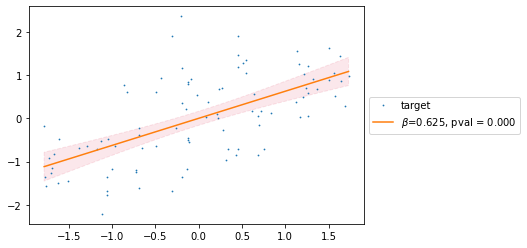

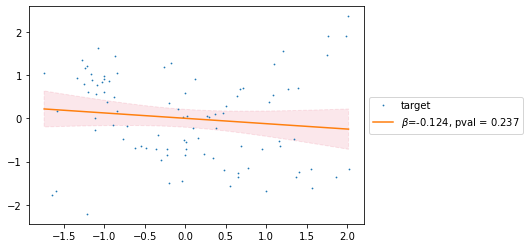

In [138]:
visualisation.plot_Linear_Reg(ROIs_coord.loc[0:92,'Y'],pipe.named_steps['pca'].pca.components_[3])
visualisation.plot_Linear_Reg(ROIs_coord.loc[0:92,'Z'],pipe.named_steps['pca'].pca.components_[3])

In [129]:
dependentVar_test,independentVar_test = data_exploration.MassUnivariate.prepare_data(df = test,
                                                                           cat_independentVar_cols=['Gender'],
                                                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+columns_names,
                                                                          dependentVar_cols=prs)
independentVar_test = independentVar_test.drop(columns='const')

In [130]:
new_X_pca = pipe.transform(independentVar_test.to_numpy())

In [131]:
new_X_pca.shape

(21, 14)

In [132]:
test_mass_univariates = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df = test,
                                                                                     thresholds = prs,
                                                                                     cont_independentVar_cols=new_X_pca[:,7:],
                                                                                     dependentVar_cols=new_X_pca[:,3]
                                                                                    )

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 82.56it/s]


In [133]:
test_mass_univariates.sort_values(by='PRS_pval').head(10)

,Connection,const_coef,const_pval,Cont_0_coef,Cont_0_pval,Cont_1_coef,Cont_1_pval,Cont_2_coef,Cont_2_pval,Cont_3_coef,Cont_3_pval,Cont_4_coef,Cont_4_pval,Cont_5_coef,Cont_5_pval,Cont_6_coef,Cont_6_pval,PRS_coef,PRS_pval,threshold
6,Dependent_Var_0,6.938894e-17,1.0,0.207373,0.392733,-1.263748,0.000472,0.849706,0.002301,-0.261191,0.163556,-0.076459,0.720536,0.063061,0.775338,0.196918,0.363149,0.544377,0.004153,PRS_0.01_ASD_Euro_LD
10,Dependent_Var_0,6.938894e-17,1.0,0.407020,0.171448,-1.418432,0.000859,0.852866,0.006216,-0.024144,0.903957,-0.296093,0.244549,-0.048681,0.847912,0.061373,0.802934,0.443688,0.031426,PRS_1_ASD_Euro_LD
7,Dependent_Var_0,6.938894e-17,1.0,0.367889,0.218480,-1.220289,0.002321,0.804518,0.010309,-0.098064,0.632784,-0.165300,0.514075,-0.011790,0.963917,0.103354,0.681719,0.401646,0.042467,PRS_0.05_ASD_Euro_LD
9,Dependent_Var_0,6.938894e-17,1.0,0.395233,0.195790,-1.394667,0.001204,0.855472,0.007362,-0.002225,0.991453,-0.264140,0.308171,-0.059872,0.819100,0.087220,0.731126,0.412357,0.047934,PRS_0.5_ASD_Euro_LD
2,Dependent_Var_0,6.938894e-17,1.0,0.238514,0.430819,-1.124591,0.005753,0.700398,0.032592,-0.051550,0.809707,-0.127382,0.634090,-0.044562,0.870033,0.053234,0.840146,0.351883,0.082351,PRS_1e-06_ASD_Euro_LD
8,Dependent_Var_0,6.938894e-17,1.0,0.339617,0.274799,-1.185744,0.003975,0.732134,0.025127,-0.093956,0.663101,-0.221971,0.405837,0.061418,0.827934,0.110873,0.676050,0.383952,0.085721,PRS_0.1_ASD_Euro_LD
3,Dependent_Var_0,6.938894e-17,1.0,0.180892,0.560221,-1.512914,0.001959,0.921208,0.007025,-0.175521,0.446799,-0.086878,0.755481,0.126743,0.676174,0.178732,0.519268,0.443061,0.112513,PRS_1e-05_ASD_Euro_LD
0,Dependent_Var_0,6.938894e-17,1.0,0.143920,0.654729,-1.031205,0.015540,0.680276,0.050900,0.003135,0.989024,-0.068164,0.814770,-0.050757,0.858303,0.075835,0.782912,0.320943,0.154550,PRS_1e-08_ASD_Euro_LD
4,Dependent_Var_0,6.938894e-17,1.0,0.267815,0.409061,-1.561028,0.004733,1.056085,0.007671,-0.163544,0.502500,-0.235461,0.409311,-0.093117,0.749649,0.092163,0.744075,0.359970,0.226935,PRS_0.0001_ASD_Euro_LD
5,Dependent_Var_0,6.938894e-17,1.0,0.320813,0.334084,-1.381903,0.003684,0.969776,0.008395,-0.163878,0.504895,-0.294897,0.319344,-0.119566,0.685713,0.002606,0.992845,0.259370,0.242410,PRS_0.001_ASD_Euro_LD


In [61]:
pipe.named_steps['pca'].X_pca.shape

(102, 5)

In [34]:
pca_scaler.covariates.shape[1]

7

In [25]:
data_exploration.MassUnivariate.mass_univariate(cont_independentVar_cols=pca_scaler.covariates,
                                               dependentVar_cols=pca_scaler.X_pca)

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7faefdb45550>,
                    const_coef  const_pval  Cont_0_coef  Cont_0_pval  \
 Dependent_Var_0  2.220446e-16         1.0    -0.233361     0.099901   
 Dependent_Var_1  1.040834e-16         1.0     0.290522     0.220988   
 Dependent_Var_2  6.938894e-17         1.0    -0.341171     0.091035   
 Dependent_Var_3 -1.387779e-17         1.0     0.020836     0.912247   
 Dependent_Var_4 -1.249001e-16         1.0    -0.159459     0.320879   
 
                  Cont_1_coef  Cont_1_pval  Cont_2_coef   Cont_2_pval  \
 Dependent_Var_0     0.399012     0.062150     7.928177  1.491566e-66   
 Dependent_Var_1    -0.254000     0.475966     0.206976  4.728614e-01   
 Dependent_Var_2     1.039196     0.000826    -0.687578  5.765722e-03   
 Dependent_Var_3     0.431477     0.131788    -0.359228  1.211080e-01   
 Dependent_Var_4     0.875618     0.000445    -0.500562  1.167368e-02   
 
                  Cont_3_coef  Cont_3_pval 

In [23]:
set1_mass_univariates

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
0,Dependent_Var_0,0.152570,0.288985,-0.216932,0.131803,0.377604,0.081003,7.943010,9.347067e-66,-0.007850,0.935334,-0.137436,0.171437,-0.014972,0.878718,-0.070035,0.478189,-0.317594,0.157282,PRS_1e-08_ASD_Euro_LD
1,Dependent_Var_1,-0.278160,0.248116,0.248323,0.300874,-0.199012,0.579709,0.168877,5.603793e-01,0.026084,0.871979,-0.004682,0.977671,0.215181,0.191896,0.179887,0.277075,0.579028,0.123620,PRS_1e-08_ASD_Euro_LD
2,Dependent_Var_2,0.105864,0.600372,-0.289549,0.152769,0.971929,0.001736,-0.640971,9.832760e-03,0.034120,0.802218,-0.007666,0.956567,0.284371,0.041751,-0.220059,0.115347,-0.220369,0.483945,PRS_1e-08_ASD_Euro_LD
3,Dependent_Var_3,0.033484,0.861885,0.045928,0.810911,0.398780,0.168258,-0.336574,1.497850e-01,0.004802,0.970490,-0.064912,0.628671,0.360057,0.007308,-0.106965,0.419628,-0.069702,0.816088,PRS_1e-08_ASD_Euro_LD
4,Dependent_Var_4,-0.188967,0.245901,-0.126242,0.436076,0.832334,0.000879,-0.470571,1.799924e-02,0.101113,0.356630,0.133014,0.241301,-0.218337,0.051501,-0.141602,0.206242,0.393360,0.121875,PRS_1e-08_ASD_Euro_LD
5,Dependent_Var_0,0.161961,0.261886,-0.209781,0.144980,0.353572,0.106489,7.955466,1.239201e-65,-0.010254,0.915376,-0.125937,0.212454,-0.006227,0.949782,-0.096970,0.348102,-0.337143,0.136143,PRS_1e-07_ASD_Euro_LD
6,Dependent_Var_1,-0.274804,0.258597,0.270301,0.263916,-0.215033,0.557744,0.183575,5.317293e-01,0.032242,0.842827,-0.013852,0.934858,0.220705,0.187297,0.083156,0.632392,0.572040,0.133465,PRS_1e-07_ASD_Euro_LD
7,Dependent_Var_2,0.124489,0.539581,-0.283058,0.162634,0.927209,0.003134,-0.620325,1.286796e-02,0.026573,0.845074,0.020400,0.885561,0.300766,0.032975,-0.238983,0.102455,-0.259141,0.414303,PRS_1e-07_ASD_Euro_LD
8,Dependent_Var_3,0.037460,0.846660,0.041628,0.828964,0.391409,0.183429,-0.335167,1.548270e-01,0.001137,0.993019,-0.055033,0.684577,0.362854,0.007505,-0.085504,0.538325,-0.077978,0.796773,PRS_1e-07_ASD_Euro_LD
9,Dependent_Var_4,-0.166501,0.303747,-0.106676,0.507002,0.773902,0.002005,-0.439478,2.637980e-02,0.096251,0.375068,0.158841,0.161533,-0.197112,0.078095,-0.217064,0.063069,0.346593,0.171733,PRS_1e-07_ASD_Euro_LD


In [55]:
model_summary = model_training.NestedCV.perform_nestedcv(
    pipe,df = df,bins=2,
                                          cat_independentVar_cols=['Gender'],
                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+columns_names,
                                          dependentVar_cols=prs,n_splits=3,scoring='r2')

In [56]:
pd.DataFrame({i:[model_summary[i][split]['test_r2_score'] for split in model_summary[i].keys()] for i in prs}).T

,0,1,2
PRS_1e-08_ASD_Euro_LD,-0.203171,-0.005448,-0.052502
PRS_1e-07_ASD_Euro_LD,-0.068232,0.057059,-0.049456
PRS_1e-06_ASD_Euro_LD,-0.287125,0.070573,-0.024034
PRS_1e-05_ASD_Euro_LD,-0.005510,-0.003562,-0.164821
PRS_0.0001_ASD_Euro_LD,0.026407,0.045557,-0.108104
PRS_0.001_ASD_Euro_LD,0.030127,0.053427,-0.042215
PRS_0.01_ASD_Euro_LD,0.042415,-0.120966,0.114993
PRS_0.05_ASD_Euro_LD,0.045222,-0.104087,-0.084327
PRS_0.1_ASD_Euro_LD,0.049147,-0.120371,-0.192523
PRS_0.5_ASD_Euro_LD,0.026935,-0.175751,-0.280489


In [ ]:
lin_reg

In [101]:
pd.DataFrame({i:[model_summary[i][split]['cv_r2_score'] for split in model_summary[i].keys()] for i in prs}).T

,0,1,2
PRS_1e-08_ASD_Euro_LD,"[0.020470588159416603, -0.030608108131903622, ...","[0.0035446024944549848, -0.03205312493637047, ...","[-0.0933690340822182, 0.021245454512250905, -0..."
PRS_1e-07_ASD_Euro_LD,"[0.028622948109082613, -0.11943668589158052, -...","[0.08869516524974885, 0.033538265270392054, -0...","[-0.1969097433667275, 0.12649983344128812, 0.0..."
PRS_1e-06_ASD_Euro_LD,"[-0.021763730344513066, -0.17889472312135668, ...","[-0.03485112592143613, 0.017695333549868297, -...","[-0.14582677552988166, 0.015913836765960254, -..."
PRS_1e-05_ASD_Euro_LD,"[-0.009747745672150199, -0.04758339578897641, ...","[0.06831726508310632, -0.015003485302910402, -...","[0.0646333089211042, 0.1115732199981182, -0.04..."
PRS_0.0001_ASD_Euro_LD,"[0.09368072487900514, 0.002127412801282369, -0...","[0.1684213043381918, -0.002749219741268183, -0...","[-0.2031405275681526, -0.04403843196028623, 0...."
PRS_0.001_ASD_Euro_LD,"[-0.09429761555810168, 0.07971829508553163, -0...","[-0.13350516026505566, -0.05526365805027744, -...","[-0.005012461888782349, 0.01791844643788132, -..."
PRS_0.01_ASD_Euro_LD,"[-0.06081412484963322, 0.017845013759780537, 0...","[0.020432791360621705, 0.0757909214228285, 0.0...","[-0.021906400602517584, -0.038764601825013845,..."
PRS_0.05_ASD_Euro_LD,"[0.03310251333810721, -0.004245412567063456, -...","[0.03748706675055047, 0.03864127283238905, 0.0...","[-0.17642315882763682, -0.1361204049885092, 0...."
PRS_0.1_ASD_Euro_LD,"[-0.061234689842185164, -0.17364594983998272, ...","[0.05087274736022296, 0.022822956908664427, -0...","[-0.09858408655429107, 0.05522984993080826, 0...."
PRS_0.5_ASD_Euro_LD,"[-0.15386737625798852, -0.1626773873861802, 0....","[-0.022357712837534294, 0.02508059562831022, -...","[0.0444335624837503, -0.12138032232283424, -0...."


In [110]:
prs_ = 'PRS_0.01_ASD_Euro_LD'
y_test_pred_dict = {i:{'y_pred':model_summary[prs_][i]['y_pred'],
   'y_test':model_summary[prs_][i]['y_test'],'split':[i for n in range(len(model_summary[prs_][i]['y_test']))]} for i in model_summary[prs_].keys()}

,const,GA_vol,PMA_vol,17 ICV (all except bone),euro_Anc_PC1,euro_Anc_PC2,euro_Anc_PC3,AAL 1,AAL 2,AAL 3,...,AAL 85,AAL 86,AAL 87,AAL 88,AAL 89,AAL 90,AAL 91,AAL 92,AAL 109,Gender_2.0
0,1.0,-0.867947,0.308270,1.838078,0.707933,0.072990,0.254428,1.037355,0.720263,1.954052,...,1.494046,2.006972,1.142841,1.242644,1.554399,1.874374,1.161712,1.020085,0.765372,0
1,1.0,-0.296195,0.308270,0.785095,-1.895899,0.408387,-2.257130,1.201847,0.931634,1.279001,...,0.124951,0.326012,0.776416,-0.109148,0.737017,0.062129,0.499356,0.639860,0.064510,0
2,1.0,-0.867947,0.811151,0.894440,-2.378463,-2.017302,-0.191470,1.129626,1.306049,0.556969,...,0.305463,1.077255,2.002414,1.625938,0.837295,0.612762,1.318961,0.958324,2.131004,0
3,1.0,1.190359,0.811151,1.607367,0.696581,0.640625,-1.137209,1.746550,1.301531,1.158332,...,1.690517,1.031688,0.422968,0.433344,1.595844,1.629106,1.593206,1.246643,1.860469,0
4,1.0,1.533410,1.062591,1.384905,1.023702,-0.120918,-0.394134,1.703406,0.999604,1.326147,...,1.333297,0.827409,-0.571724,-0.073647,0.949096,0.924231,0.928284,0.800947,1.262021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1.0,0.504257,-0.278424,-0.785043,0.314708,0.218152,1.565692,-0.812053,-0.615507,-0.895339,...,-0.565591,-0.778999,-0.858757,0.011776,-0.364415,-0.862511,-0.765616,-0.708282,-0.418876,0
201,1.0,1.419060,0.308270,-0.177393,0.893955,-0.578483,0.056851,-0.556549,-0.386908,-0.229354,...,0.386582,0.208916,-0.449582,-0.822486,-0.300125,-0.314727,0.269697,0.363599,0.225227,1
202,1.0,-1.897100,0.643524,0.018181,0.711032,-0.018205,0.894654,0.160938,0.394489,-0.327604,...,-0.548970,0.320820,-0.406069,0.001237,0.430929,-0.194806,-0.148887,0.172752,-0.037288,1
203,1.0,0.847308,0.643524,0.690544,0.130952,-1.068898,0.989428,0.633420,1.031961,0.811328,...,0.791183,0.764715,0.519155,0.432789,0.680005,0.534352,0.864534,1.091121,0.679923,1


## Clustering

### AAL atlas

In [356]:
# AAL_cols = [i for i in df.columns if re.search('AAL \d',i)]
# Imperial_cols = [i for i in df.columns if re.search('Imperial \d',i) and i in cor_labels]
# prs_labels = [i for i in df.columns if 'euro_ld_no_dups_gen' in i]


# _, prs_pca, prs_loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(df,
#                                                               dependentVar_cols=prs_labels,n_components=1,scaling=True)
# pca, X_pca, brain_loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
#     df=df,
#     dependentVar_cols=AAL_cols,
#     scaling=True,n_components = .8)

# df['Brain_PC5'] = X_pca[:,4]
# df['PRS_pca'] = prs_pca

In [359]:
# prs_loading_matrix = df[[f'AAL {i}' for i in list(range(1, 93)) + [109]]].apply(
#     lambda x: np.corrcoef(x.values, df['PRS_pca'].values)[0, 1],
#     axis=0)

# brain_loading_matrix = df[[f'AAL {i}' for i in list(range(1, 93)) + [109]]].apply(
#     lambda x: np.corrcoef(x.values, df['Brain_PC5'])[0, 1],
#     axis=0)

In [22]:
ROIs_coord_AAL = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')
standardized_ROIs_coord = ROIs_coord_AAL.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(ROIs_coord_AAL[['X','Y','Z']])
standardized_ROIs_coord['Label'] = [f'AAL {int(i)}' for i in standardized_ROIs_coord['Label']]

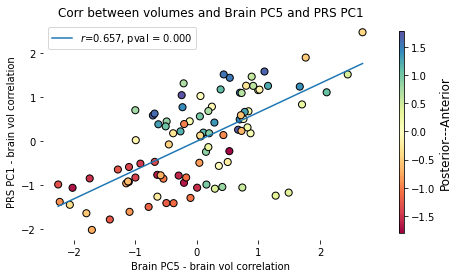

In [24]:
visualisation.simple_plots.Scatter(x=prs_loading_matrix,
                                   y=brain_loading_matrix,
                                   colorby=standardized_ROIs_coord.set_index('Label').loc[prs_loading_matrix.index,'Y'],
                                  markersize=50,legend_loc='upper left',colorbar_label='Posterior---Anterior',
                                  cmap='Spectral',hide_CI=True,title='Corr between volumes and Brain PC5 and PRS PC1',
                                  xlabel='Brain PC5 - brain vol correlation',
                                  ylabel='PRS PC1 - brain vol correlation',scaling='both',edgecolors='k')
sns.despine(bottom=True,left=True)

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [39]:
corr_matrices = np.concatenate([prs_loading_matrix.values.reshape(-1,1),
               brain_loading_matrix.values.reshape(-1,1)],axis=1)

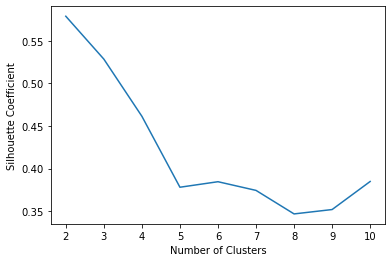

In [40]:
kmeans_kwargs= {
    "init":"random",
    "n_init":10,
    "max_iter":300,
    "random_state":42
}
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(corr_matrices)
    score = silhouette_score(corr_matrices, kmeans.labels_)
    silhouette_coefficients.append(score)
    
# Plotting graph to choose the best number of clusters
# with the most Silhouette Coefficient score


plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [41]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(corr_matrices)

KMeans(init='random', n_clusters=2, random_state=42)

In [42]:
kmeans_clusters = pd.DataFrame({'PRS-cor':prs_loading_matrix,
            'Brain-cor':brain_loading_matrix,
             'cluster':kmeans.predict(corr_matrices)})

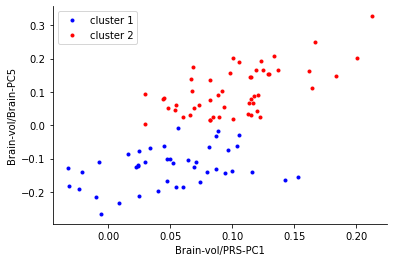

In [43]:
ax = plt.subplot(111)
ax.plot(kmeans_clusters.loc[kmeans_clusters['cluster']==0,'PRS-cor'],
        kmeans_clusters.loc[kmeans_clusters['cluster']==0,'Brain-cor'],'b.',label='cluster 1')
ax.plot(kmeans_clusters.loc[kmeans_clusters['cluster']==1,'PRS-cor'],
        kmeans_clusters.loc[kmeans_clusters['cluster']==1,'Brain-cor'],'r.',label='cluster 2')

ax.legend()
ax.set_xlabel('Brain-vol/PRS-PC1')
ax.set_ylabel('Brain-vol/Brain-PC5')
sns.despine()

In [192]:
kmeans_clusters[kmeans_clusters['cluster']==0].index

Index(['AAL 1', 'AAL 7', 'AAL 8', 'AAL 9', 'AAL 11', 'AAL 12', 'AAL 13',
       'AAL 14', 'AAL 15', 'AAL 16', 'AAL 17', 'AAL 18', 'AAL 21', 'AAL 22',
       'AAL 23', 'AAL 24', 'AAL 31', 'AAL 32', 'AAL 33', 'AAL 34', 'AAL 40',
       'AAL 41', 'AAL 42', 'AAL 54', 'AAL 55', 'AAL 56', 'AAL 79', 'AAL 80',
       'AAL 81', 'AAL 82', 'AAL 84', 'AAL 88', 'AAL 89', 'AAL 90'],
      dtype='object')

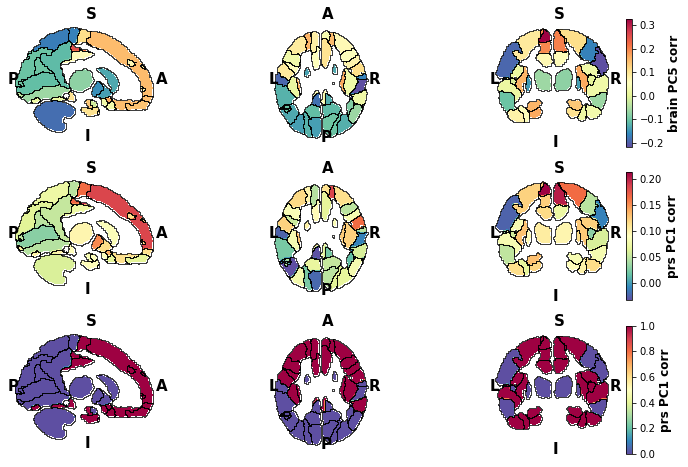

In [138]:
plot_labels = [int(i.replace('AAL ','')) for i in brain_loading_matrix.index]
brain_plot_value_values = brain_loading_matrix.values
brain_plot_values = dict(zip(plot_labels,brain_plot_value_values)) 

prs_plot_value_values = prs_loading_matrix.values
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 


cluster_plot_value_values = kmeans_clusters.cluster.values
cluster_plot_values = dict(zip(plot_labels,cluster_plot_value_values)) 

fig,ax = plt.subplots(3,3,figsize=(12,8))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=brain_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[0],
    fig=fig,
    cb_title='brain PC5 corr')

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[1],
    fig=fig,
    cb_title='prs PC1 corr')

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=cluster_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[2],
    fig=fig,
    cb_title='prs PC1 corr')
# fig.savefig('./brain_plots.png')

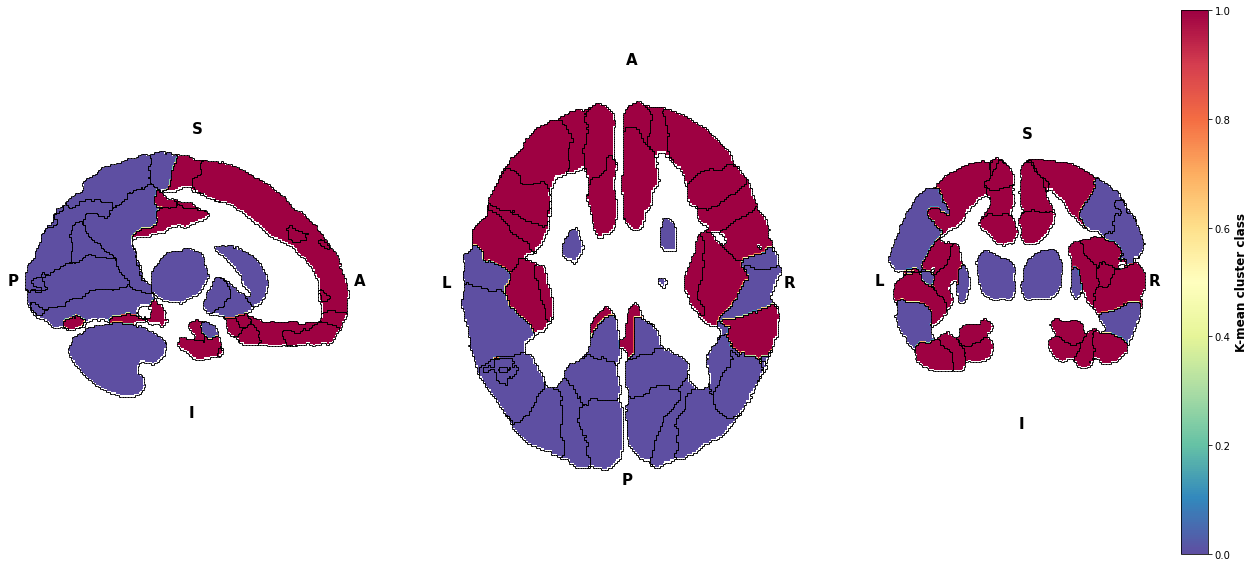

In [219]:
plot_labels = [int(i.replace('AAL ','')) for i in brain_loading_matrix.index]

cluster_plot_value_values = kmeans_clusters.cluster.values
cluster_plot_values = dict(zip(plot_labels,cluster_plot_value_values)) 

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=cluster_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    fig=fig,
    cb_title='K-mean cluster class')

In [363]:
ROIs_coord_AAL = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

In [102]:
standardized_ROIs_coord = ROIs_coord_AAL.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(ROIs_coord_AAL[['X','Y','Z']])

In [103]:
standardized_ROIs_coord[standardized_ROIs_coord['Y']<0]
posterior_labels = standardized_ROIs_coord.loc[standardized_ROIs_coord['Y']<=0,'Label'].to_list()
anterior_labels = standardized_ROIs_coord.loc[standardized_ROIs_coord['Y']>0,'Label'].to_list()

In [104]:
df['Anterior_volumes'] = df[[f'AAL {int(i)}' for i in anterior_labels if f'AAL {int(i)}' in df.columns]].sum(axis=1)
df['Posterior_volumes'] = df[[f'AAL {int(i)}' for i in posterior_labels  if f'AAL {int(i)}' in df.columns]].sum(axis=1)

In [220]:
cluster_0_labels = kmeans_clusters[kmeans_clusters['cluster']==0].index.tolist()
cluster_1_labels = kmeans_clusters[kmeans_clusters['cluster']==1].index.tolist()

In [221]:
df['cluster1_volume'] = df[cluster_1_labels].sum(axis=1)
df['cluster0_volume'] = df[cluster_0_labels].sum(axis=1)

In [105]:
_, clusters_mass_univariate = data_exploration.MassUnivariate.mass_univariate(df,
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['PMA_vol','GA_vol','PRS_pca',
                                                                           '17 TOTAL BRAIN TISSUE VOLUME (mm3)']+ancestry,
                                                  dependentVar_cols=['Anterior_volumes','Posterior_volumes'],
                                                                       scaling='both')

In [230]:
clusters_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df,
                                                                                                                thresholds=prs_labels,
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['PMA_vol','GA_vol',
                                                                           '17 TOTAL BRAIN TISSUE VOLUME (mm3)']+ancestry,
                                                  dependentVar_cols=['cluster0_volume','cluster1_volume','Anterior_volumes','Posterior_volumes'],
                                                                       scaling='both')

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 34.41it/s]


In [107]:
clusters_mass_univariate.sort_values(by='PRS_pca_pval')

,const_coef,const_pval,PMA_vol_coef,PMA_vol_pval,GA_vol_coef,GA_vol_pval,PRS_pca_coef,PRS_pca_pval,17 TOTAL BRAIN TISSUE VOLUME (mm3)_coef,17 TOTAL BRAIN TISSUE VOLUME (mm3)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Gender_2.0_coef,Gender_2.0_pval
Anterior_volumes,-0.035503,0.076785,-0.005271,0.845412,-0.030009,0.098628,0.039611,0.005178,0.987410,8.886430e-112,0.021773,0.128477,-0.031000,0.028936,0.007661,0.591769,0.074373,0.016301
Posterior_volumes,-0.032415,0.057425,0.085683,0.000237,0.004714,0.759504,-0.026616,0.026615,0.929816,4.207554e-121,-0.012460,0.305403,0.006325,0.598237,-0.017107,0.159626,0.067904,0.009937


<AxesSubplot:xlabel='Adj. PRS_pca', ylabel='Adj. Total Cluster 1 volumes'>

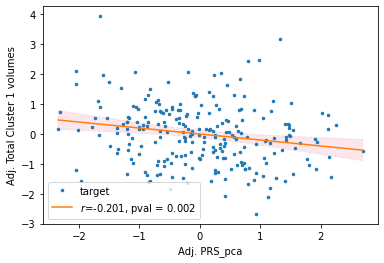

In [172]:
visualisation.simple_plots.plot_Linear_Reg(x='PRS_pca',
                                          y='cluster0_volume',data=df,adjust_covar={'x':ancestry,
                                                                                   'y':['PMA_vol','GA_vol','17 TOTAL BRAIN TISSUE VOLUME (mm3)']},markersize=5,legend_loc='inside',ylabel='Total Cluster 1 volumes')

<AxesSubplot:xlabel='Adj. PRS_pca', ylabel='Adj. cluster1_volume'>

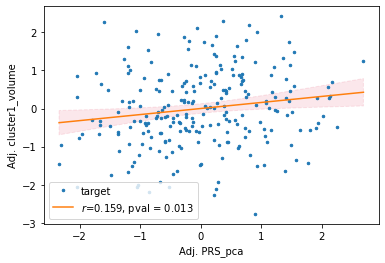

In [168]:
visualisation.simple_plots.plot_Linear_Reg(x='PRS_pca',
                                          y='cluster1_volume',data=df,adjust_covar={'x':ancestry,
                                                                                   'y':['PMA_vol','GA_vol','17 TOTAL BRAIN TISSUE VOLUME (mm3)']},markersize=5,legend_loc='inside')

In [229]:
adjusted_PRS = df

['AAL 1',
 'AAL 2',
 'AAL 3',
 'AAL 4',
 'AAL 5',
 'AAL 6',
 'AAL 7',
 'AAL 8',
 'AAL 9',
 'AAL 10',
 'AAL 11',
 'AAL 12',
 'AAL 13',
 'AAL 14',
 'AAL 15',
 'AAL 16',
 'AAL 17',
 'AAL 18',
 'AAL 19',
 'AAL 20',
 'AAL 22',
 'AAL 23',
 'AAL 24',
 'AAL 25',
 'AAL 26',
 'AAL 27',
 'AAL 28',
 'AAL 29',
 'AAL 30',
 'AAL 31',
 'AAL 32',
 'AAL 33',
 'AAL 34',
 'AAL 37',
 'AAL 38',
 'AAL 39',
 'AAL 40',
 'AAL 41',
 'AAL 55',
 'AAL 56',
 'AAL 69',
 'AAL 70',
 'AAL 80',
 'AAL 81',
 'AAL 82',
 'AAL 83',
 'AAL 84',
 'AAL 87',
 'AAL 88',
 'AAL 89',
 'AAL 90']

### Imperial atlas

In [74]:
Imperial_cols = [i for i in df.columns if re.search('Imperial \d',i)]
Imperial_cols = data_preprocessing.Volumes.Imperial.get_segment(Imperial_cols,tissue = ['WM','GM'])
prs_labels = [i for i in df.columns if 'ASD_PRS' in i]

_, prs_pca, prs_loading_matrix = stats.FeatureReduction.perform_PCA(df,
                                                              dependentVar_cols=prs_labels,n_components=1,scaling=True)
pca, X_pca, brain_loading_matrix = stats.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=Imperial_cols,
    scaling=True,n_components = .8)

# df['Brain_PC5'] = X_pca[:,4]
df['PRS_pca'] = prs_pca

In [97]:
data_exploration.matSpDLite(np.corrcoef(df[Imperial_cols],rowvar=False))

Effective Number of Independent Variables [Veff] is 61.35814879707756
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 41.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.001219512195121951


41.00000000000001

In [102]:
len(Imperial_cols)

65

In [101]:
np.mean(data_preprocessing.Diffusion.lower_triangle(np.corrcoef(df[Imperial_cols])))

0.9937814422147573

In [94]:
test = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=['PRS_pca'],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=[
        'GA', 'PMA'
    ] + ancestry,
    dependentVar_cols=Imperial_cols,
    scaling='both')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 47.57it/s]


In [51]:
0.05/6

0.008333333333333333

In [95]:
test.sort_values(by='PRS_pval').groupby('Connection').head(1)

,Connection,const_coef,const_pval,GA_coef,GA_pval,PMA_coef,PMA_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,sex_male_coef,sex_male_pval,threshold
1,Posterior_volumes,-0.135951,0.104058,0.048090,0.504020,0.229598,0.001784,0.007922,0.894004,0.089262,0.134217,-0.016164,0.786181,-0.178787,0.002680,0.265105,0.024128,PRS_pca
0,Anterior_volumes,-0.129032,0.100063,-0.100473,0.137356,-0.330869,0.000002,0.070050,0.209809,-0.130342,0.020104,0.068256,0.222651,0.154572,0.005596,0.251612,0.022525,PRS_pca


In [55]:
from statsmodels.stats.multitest import fdrcorrection

In [56]:
fdrcorrection(test['PRS_pval'],alpha=0.05)

(array([ True,  True, False, False,  True,  True]),
 array([0.03027755, 0.03027755, 0.3741493 , 0.20549124, 0.01721404,
        0.01721404]))

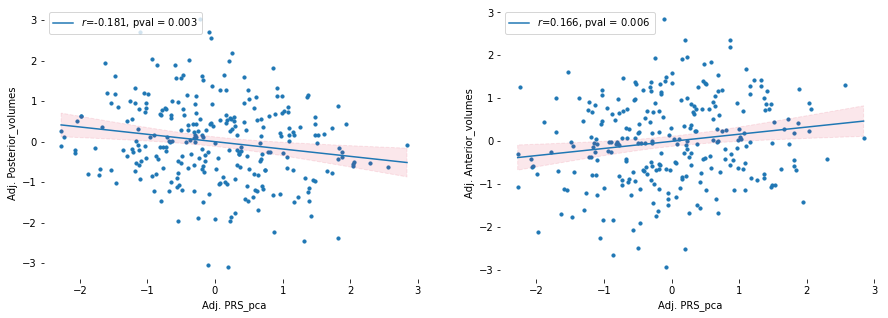

In [96]:
fig,axes=plt.subplots(1,2,sharey=False,figsize=(15,5))
visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='Frontal_lobe_TTV',data=df,
                                  adjust_covar={'x':ancestry,'y':['sex','GA','PMA']},
                                  scaling='both',ax=axes[0],legend_loc='upper left',markersize=10,
                                  )

visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='Parietal_lobe_TTV',data=df,
                                  adjust_covar={'x':ancestry,'y':['sex','GA','PMA']},
                                  scaling='both',ax=axes[1],legend_loc='upper left',markersize=10)
sns.despine(left=True,bottom=True)

In [83]:
frontal_lobes = data_preprocessing.Volumes.Imperial.get_segment(
    df,col='column',lobe=['frontal'])
temporal_lobes = data_preprocessing.Volumes.Imperial.get_segment(
    df,col='column',lobe=['temporal'])
occipital_lobes = data_preprocessing.Volumes.Imperial.get_segment(
    df,col='column',lobe=['occipital'])
parietal_lobes = data_preprocessing.Volumes.Imperial.get_segment(
    df,col='column',lobe=['parietal'])

In [84]:
for i in frontal_lobes.columns:
    df[i] = df['Frontal_lobe_TTV']
for i in temporal_lobes.columns:
    df[i] = df['Temporal_lobe_TTV']
for i in occipital_lobes.columns:
    df[i] = df['Occipital_lobe_TTV']
for i in parietal_lobes.columns:
    df[i] = df['Parietal_lobe_TTV']

In [85]:
lobes = data_preprocessing.Volumes.Imperial.get_segment(
    df,col='column',lobe=['frontal','temporal','occipital','parietal'])

In [88]:
adjusted_df = data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(df,
                                                              cat_independentVar_cols=['sex'],
                                                              cont_independentVar_cols=['GA','PMA']+ancestry,
                                                              dependentVar_cols=lobes.columns.tolist())

prs_loading_matrix = adjusted_df.apply(lambda x: np.corrcoef(x.values, prs_pca[:,0])[0, 1], axis=0)


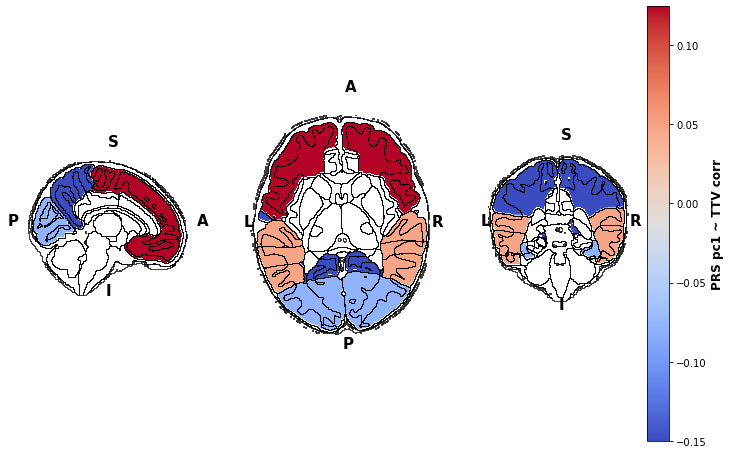

In [90]:
plot_labels = [int(i.replace('Imperial ','')) for i in prs_loading_matrix.index]
# brain_plot_value_values = brain_loading_matrix.values
# brain_plot_values = dict(zip(plot_labels,brain_plot_value_values)) 

prs_plot_value_values = prs_loading_matrix.values
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 

# cluster_plot_value_values = kmeans_clusters.cluster.values
# cluster_plot_values = dict(zip(plot_labels,cluster_plot_value_values)) 

fig,ax = plt.subplots(1,3,figsize=(12,8))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
#     atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap='coolwarm',
    cmap_reversed=False,
    axes=ax,
    fig=fig,
    cb_title='PRS pc1 ~ TTV corr')


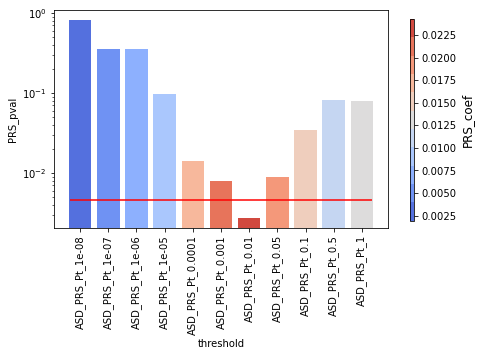

In [74]:
visualisation.simple_plots.Bar(x='threshold',
                              y='PRS_pval',
                              colorby='PRS_coef',
                               yscalelog=True,
                               order={'x':prs_labels},
                               order_reversed=True,hline=0.05/11,
                              data=test,rotation_x=90)

# plt.title('association with Fronto-temporal TTV')

In [84]:
prs_loading_matrix = df[Imperial_cols].apply(lambda x: np.corrcoef(x.values, prs_pca[:,0])[0, 1], axis=0)

# brain_loading_matrix = df[[
#     i for i in cor_labels if bool(re.search('Imperial \d', i))
# ]].apply(lambda x: np.corrcoef(x.values, X_pca[:,4])[0, 1], axis=0)

In [85]:
ROIs_coord_Imperial = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/Imperial/atlas_t40.nii.gz')

ROIs_coord_Imperial['Label'] = [f'Imperial {int(i)}' for i in ROIs_coord_Imperial['Label']]

In [86]:
new_ROIs_coord_Imperial = ROIs_coord_Imperial.set_index('Label').T.copy()
new_ROIs_coord_Imperial = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(new_ROIs_coord_Imperial,grouping=None,operation='mean',remove_duplicated=False).T
new_ROIs_coord_Imperial = new_ROIs_coord_Imperial.drop([i for i in new_ROIs_coord_Imperial.index if not bool(re.search('Imperial \d',i))])

In [87]:
standardized_ROIs_coord = new_ROIs_coord_Imperial.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(new_ROIs_coord_Imperial[['X','Y','Z']])

In [88]:
Imperial_labels = data_preprocessing.Volumes.Imperial.get_Imperial_legends(grouping='gmwm2gether')

In [89]:
visualisation.simple_plots.Scatter(x=standardized_ROIs_coord.loc[prs_loading_matrix.index,'Y'],
                                  y=prs_loading_matrix, annotate=[Imperial_labels[i]['abbr'] for i in prs_loading_matrix.index])

KeyError: 'abbr'

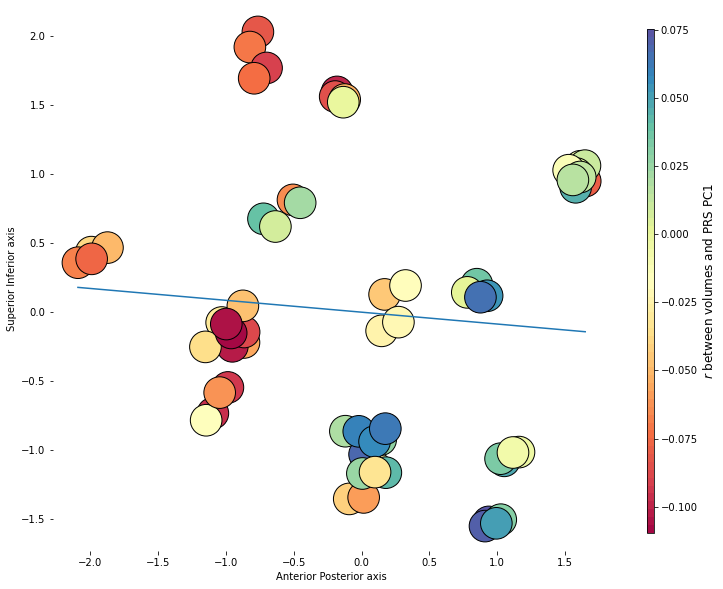

In [80]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
visualisation.simple_plots.Scatter(x=standardized_ROIs_coord.loc[prs_loading_matrix.index,'Y'],
                                   y=standardized_ROIs_coord.loc[prs_loading_matrix.index,'Z'],
#                                    annotate=[Imperial_labels[i]['abbr'] for i in prs_loading_matrix.index],
                                   colorby=prs_loading_matrix,colorbar_label='$r$ between volumes and PRS PC1',
                                  markersize=1000,legend_loc='upper left',
                                  cmap='Spectral',hide_CI=True,
                                  xlabel='Anterior Posterior axis',
                                  ylabel='Superior Inferior axis',edgecolors='k',scaling='both',ax=ax,stats=True,legend=False,fig=fig)
sns.despine(bottom=True,left=True)

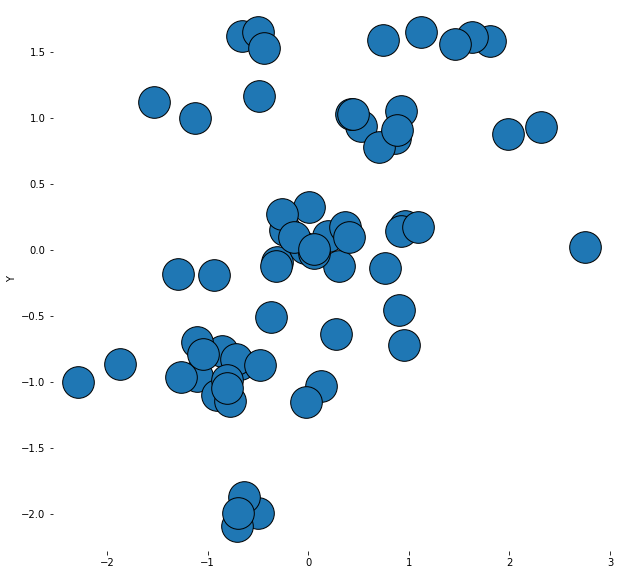

In [70]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
visualisation.simple_plots.Scatter(x=prs_loading_matrix,
                                   y=standardized_ROIs_coord.loc[prs_loading_matrix.index,'Y'],
#                                    annotate=[Imperial_labels[i]['abbr'] for i in prs_loading_matrix.index],
#                                    colorby=prs_loading_matrix,colorbar_label='$r$ between volumes and PRS PC1',
                                  markersize=1000,legend_loc='upper left',
                                  cmap='Spectral',hide_CI=True,
#                                   xlabel='Anterior Posterior axis',
#                                   ylabel='Superior Inferior axis',
                                   edgecolors='k',scaling='both',ax=ax,stats=True,legend=False,fig=fig)
sns.despine(bottom=True,left=True)

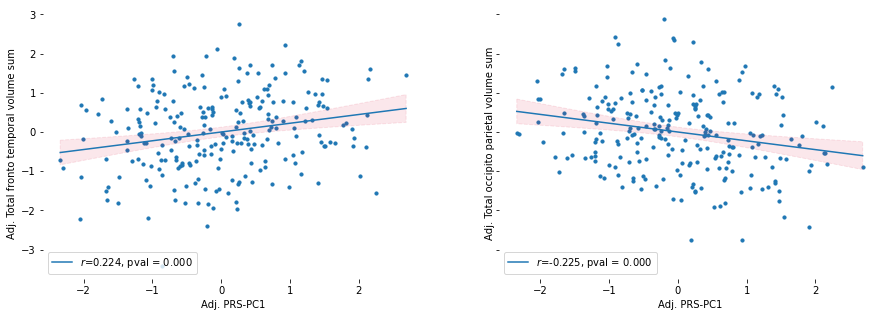

In [54]:
fig,ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='Fronto_temporal_lobe_TTV',
                                  data=df,adjust_covar={'x':ancestry,
                                                       'y':['PMA_vol','GA_vol',    
                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']},
                                  markersize=10,
                                   xlabel='PRS-PC1',
                                  ylabel='Total fronto temporal volume sum',
                                  ax=ax[0],legend_loc='lower left',stats=False)

visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='Parieto_occipital_lobe_TTV',
                                  data=df,adjust_covar={'x':ancestry,
                                                       'y':['PMA_vol','GA_vol',    
                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']},
                                  markersize=10,
                                   xlabel='PRS-PC1',
                                  ylabel='Total occipito parietal volume sum',
                                  ax=ax[1],legend_loc='lower left',stats=False)
sns.despine(bottom=True,left=True)

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [33]:
corr_matrices = np.concatenate([prs_loading_matrix.values.reshape(-1,1),
                                standardized_ROIs_coord.loc[prs_loading_matrix.index,'Y'].values.reshape(-1,1),
                                standardized_ROIs_coord.loc[prs_loading_matrix.index,'Z'].values.reshape(-1,1)],axis=1)

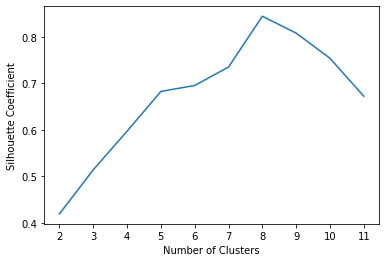

In [35]:
kmeans_kwargs= {
    "init":"random",
    "n_init":12,
    "max_iter":300,
    "random_state":42
}
silhouette_coefficients = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(corr_matrices)
    score = silhouette_score(corr_matrices, kmeans.labels_)
    silhouette_coefficients.append(score)
    
# Plotting graph to choose the best number of clusters
# with the most Silhouette Coefficient score


plt.plot(range(2, 12), silhouette_coefficients)
plt.xticks(range(2, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [36]:
n_clusters=8
kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(corr_matrices)

KMeans(init='random', random_state=42)

In [150]:
kmeans_clusters = pd.DataFrame({'PRS-cor':prs_loading_matrix,
            'Brain-cor':brain_loading_matrix,
             'cluster':kmeans.predict(corr_matrices)})

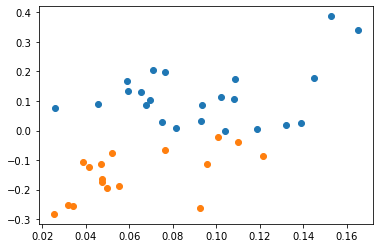

In [151]:
for i in range(5):
    plt.scatter(kmeans_clusters.loc[kmeans_clusters['cluster']==i,'PRS-cor'],
            kmeans_clusters.loc[kmeans_clusters['cluster']==i,'Brain-cor'])

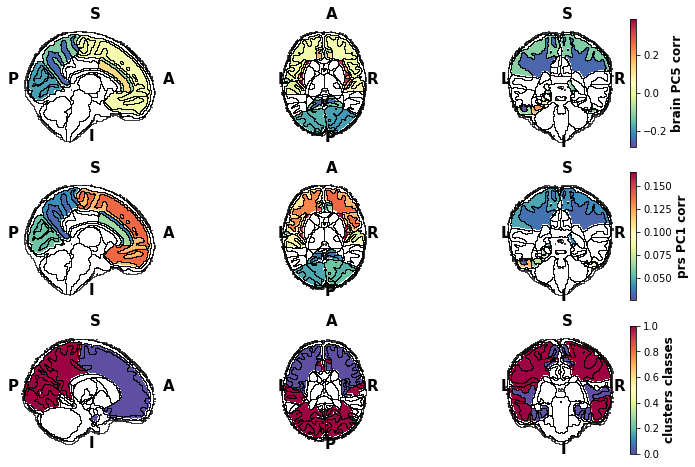

In [152]:
plot_labels = [int(i.replace('Imperial ','')) for i in brain_loading_matrix.index]
brain_plot_value_values = brain_loading_matrix.values
brain_plot_values = dict(zip(plot_labels,brain_plot_value_values)) 

prs_plot_value_values = prs_loading_matrix.values
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 


cluster_plot_value_values = kmeans_clusters.cluster.values
cluster_plot_values = dict(zip(plot_labels,cluster_plot_value_values)) 

fig,ax = plt.subplots(3,3,figsize=(12,8))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
#     atlas_slice=120,
    plot_values=brain_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[0],
    fig=fig,
    cb_title='brain PC5 corr')

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
#     atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[1],
    fig=fig,
    cb_title='prs PC1 corr')

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=cluster_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[2],
    fig=fig,
    cb_title='clusters classes')

# fig.savefig('./brain_plots.png')

In [90]:
standardized_ROIs_coord = new_ROIs_coord_Imperial.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(new_ROIs_coord_Imperial[['X','Y','Z']])

In [91]:
posterior_labels = standardized_ROIs_coord[standardized_ROIs_coord['Y']<=0].index.to_list()
anterior_labels = standardized_ROIs_coord[standardized_ROIs_coord['Y']>0].index.to_list()

In [92]:
df['Anterior_volumes'] = df[[i for i in anterior_labels if i in Imperial_cols]].sum(axis=1)
df['Posterior_volumes'] = df[[i for i in posterior_labels if i in Imperial_cols]].sum(axis=1)

In [156]:
cluster_0_labels = kmeans_clusters[kmeans_clusters['cluster']==0].index.tolist()
cluster_1_labels = kmeans_clusters[kmeans_clusters['cluster']==1].index.tolist()

In [157]:
df['cluster1_volume'] = df[cluster_1_labels].sum(axis=1)
df['cluster0_volume'] = df[cluster_0_labels].sum(axis=1)

In [158]:
_, clusters_mass_univariate = data_exploration.MassUnivariate.mass_univariate(df,
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['PMA_vol','GA_vol','PRS_pca',
                                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']+ancestry,
                                                  dependentVar_cols=['cluster0_volume','cluster1_volume',
                                                                     'Anterior_volumes','Posterior_volumes'],
                                                                       scaling='both')

In [159]:
clusters_mass_univariate

,const_coef,const_pval,PMA_vol_coef,PMA_vol_pval,GA_vol_coef,GA_vol_pval,PRS_pca_coef,PRS_pca_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,Total_Brain_Volume_Imperial_coef,Total_Brain_Volume_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Gender_2.0_coef,Gender_2.0_pval
cluster0_volume,-0.002664,0.869664,-0.120563,9.445230e-08,0.002096,0.886246,0.037592,0.001098,0.000346,0.994559,1.060683,1.544160e-53,0.018147,0.117313,-0.020115,0.079372,0.018055,0.118892,0.005581,0.823899
cluster1_volume,0.016790,0.308265,0.003479,8.754875e-01,0.015858,0.286330,-0.036733,0.001639,0.028626,0.577458,0.952310,5.188621e-46,-0.012933,0.270239,0.017594,0.129768,-0.010659,0.362936,-0.035171,0.167421
Anterior_volumes,-0.007331,0.661283,-0.115542,6.203962e-07,0.004371,0.772176,0.038241,0.001264,0.057415,0.272000,1.001898,4.353106e-48,0.017185,0.149783,-0.017759,0.132380,0.017200,0.149117,0.015356,0.552431
Posterior_volumes,0.019373,0.199424,-0.008815,6.645960e-01,0.013125,0.335021,-0.032452,0.002362,-0.019948,0.671514,1.010044,3.226983e-55,-0.010126,0.345600,0.013218,0.213434,-0.008091,0.450591,-0.040582,0.082256


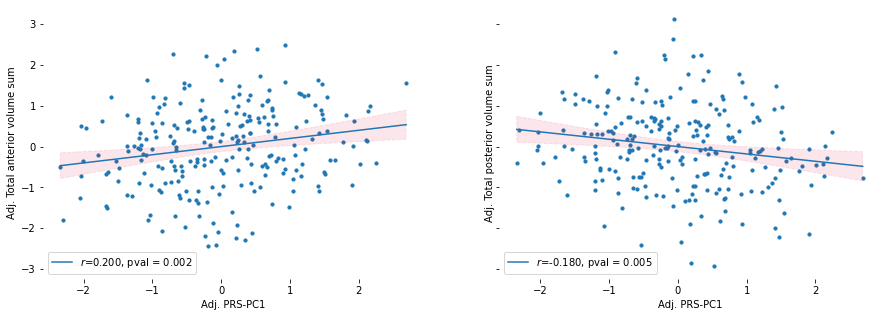

In [160]:
fig,ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='Anterior_volumes',
                                  data=df,adjust_covar={'x':ancestry,
                                                       'y':['PMA_vol','GA_vol',    
                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']},
                                  markersize=10,
                                   xlabel='PRS-PC1',
                                  ylabel='Total anterior volume sum',
                                  ax=ax[0],legend_loc='lower left')

visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='Posterior_volumes',
                                  data=df,adjust_covar={'x':ancestry,
                                                       'y':['PMA_vol','GA_vol',    
                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']},
                                  markersize=10,
                                   xlabel='PRS-PC1',
                                  ylabel='Total posterior volume sum',
                                  ax=ax[1],legend_loc='lower left')
sns.despine(bottom=True,left=True)

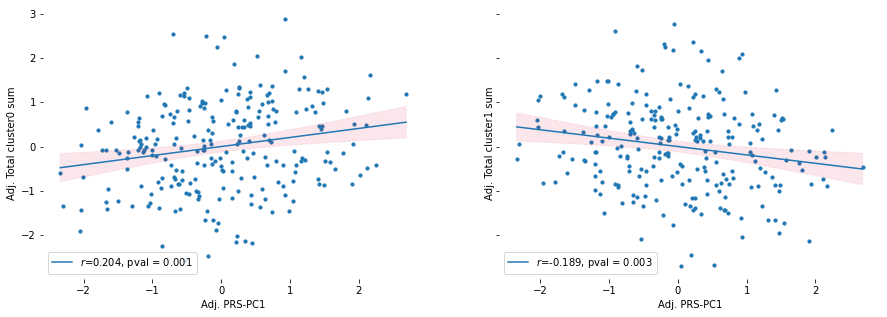

In [161]:
fig,ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='cluster0_volume',
                                  data=df,adjust_covar={'x':ancestry,
                                                       'y':['PMA_vol','GA_vol',    
                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']},
                                  markersize=10,
                                   xlabel='PRS-PC1',
                                  ylabel='Total cluster0 sum',
                                  ax=ax[0],legend_loc='lower left')

visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='cluster1_volume',
                                  data=df,adjust_covar={'x':ancestry,
                                                       'y':['PMA_vol','GA_vol',    
                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']},
                                  markersize=10,
                                   xlabel='PRS-PC1',
                                  ylabel='Total cluster1 sum',
                                  ax=ax[1],legend_loc='lower left')
sns.despine(bottom=True,left=True)